# Pump it Up: Data Mining the Water Table

#### Analysed By :  Osafa Karim (osafa.karim@gmail.com)
#### Analysed On : 4th July 2019
#### Analysed for : Axiata Analytics - Employment Test

##### Python kernel Used

In [1]:
# kernel used
from platform import python_version
print('The version of ',python_version())

The version of  3.6.8


In [2]:
# importing the data-analysis and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
%matplotlib inline

import os
import requests

import re 
import geopy.distance

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

##### Download the data set for analyses from the url as is in the 
##### https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/

In [3]:
def download_data(url, file_name):
    '''
    input : 
       1. url - the url from where the file has to be downloaded
       2. file_name - the name with with the corresponding file has to be created 
    '''
    if file_name not in os.listdir():
        t0 = datetime.now()
        response = requests.get(url)
        with open(os.path.join(os.getcwd(), file_name), 'wb') as f:
            f.write(response.content)
        
        print('****** File ', file_name,', of size :',os.path.getsize(file_name)/1000000 ,' MB sucessfully downloaded in ',
             str((datetime.now()- t0).seconds),' seconds !!!!.')
    else:
        print('****** File with name ',file_name,' already exists. Please verify.')
        


In [4]:
# training-set values
url = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
file_name = 'raw_train_feature_vectors.csv'
download_data(url, file_name)

****** File with name  raw_train_feature_vectors.csv  already exists. Please verify.


In [5]:
# training-set labels
url = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
file_name = 'raw_train_target_vectors.csv'
download_data(url, file_name)

****** File with name  raw_train_target_vectors.csv  already exists. Please verify.


In [6]:
# testing-set values
url = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'
file_name = 'raw_test_feature_vectors.csv'
download_data(url, file_name)

****** File with name  raw_test_feature_vectors.csv  already exists. Please verify.


#### Data Description

In [7]:
# train data-set 

train_data = pd.read_csv('raw_train_feature_vectors.csv')

In [8]:
print('There {} features and {} data-points in train-data set.'.format(train_data.shape[1],train_data.shape[0]))

There 40 features and 59400 data-points in train-data set.


In [9]:
# get the data-types of the features
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [10]:
# Casting the data types of date fileds to datetime dtype
train_data['date_recorded'] = pd.to_datetime(train_data['date_recorded'])
#train_data['construction_year'] = pd.to_datetime(train_data['construction_year'])

##### Check for missing data 


In [11]:
#train_data.isna().sum()
for a in train_data.columns[train_data.isna().any()].tolist():
    print(a ,' has ',train_data[train_data[a].isna()].shape[0],' missing values')

funder  has  3635  missing values
installer  has  3655  missing values
subvillage  has  371  missing values
public_meeting  has  3334  missing values
scheme_management  has  3877  missing values
scheme_name  has  28166  missing values
permit  has  3056  missing values


In [12]:
# Count of types of features
categorical = len(train_data.select_dtypes(include='object').columns)
integ = len(train_data.select_dtypes(include='int64').columns)
float_num = len(train_data.select_dtypes(include='float64').columns)
date_time = len(train_data.select_dtypes(include='datetime64[ns]').columns)


In [13]:
categorical, integ, float_num, date_time

(29, 7, 3, 1)

In [14]:
dty_list =[]

for a, b in zip([categorical, integ, float_num, date_time],['categorical', 'integ', 'float_num', 'date_time']):
    for _ in range(a):
            dty_list.append(b)
    

Text(0.5, 1.0, ' Comparison of the fetaures by dtypes')

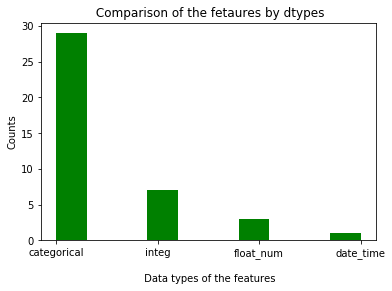

In [15]:
plt.hist(dty_list, color = 'green')
plt.xlabel('\n Data types of the features')
plt.ylabel('Counts')
plt.title(' Comparison of the fetaures by dtypes')

In [16]:
# Start dissecting the categorical features 
[ col for col in train_data.columns if train_data[col].dtypes == 'object']

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

###### Let's visualize and analyze each of the categorical features for more insights .
###### 1. Funder -  Let's visualize the top 30 Organizations who have funded the water-resources

In [17]:
fund_30 = pd.DataFrame(train_data['funder'].value_counts().head(30))

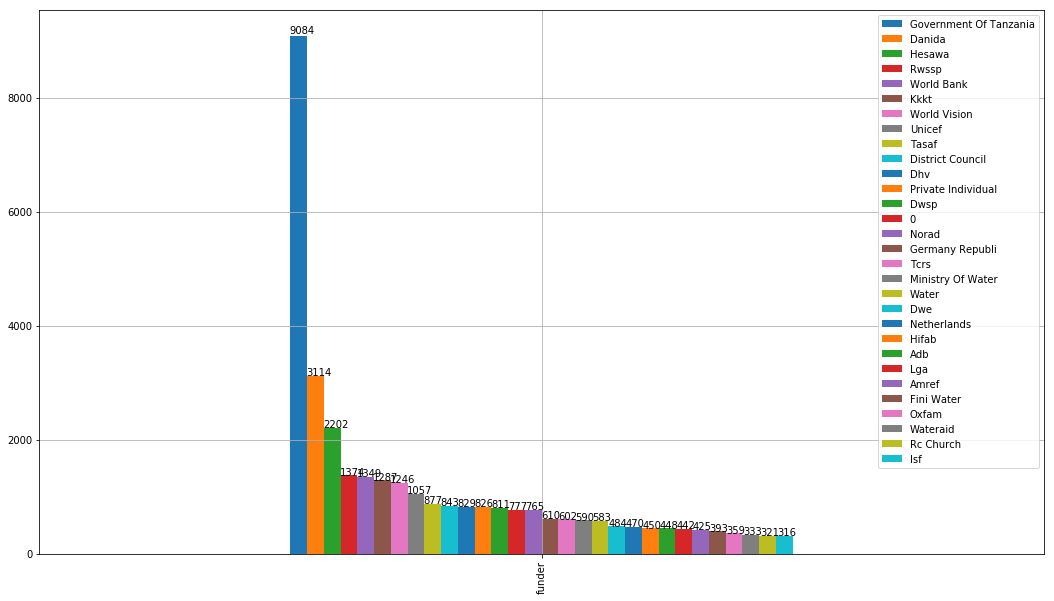

In [18]:
ax = fund_30.T.plot(kind='bar', figsize = (18, 10) , grid = True )
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 2. Installer  -  Let's visualize top 30 installers 

In [19]:
install_30 = pd.DataFrame(train_data['installer'].value_counts().head(30))

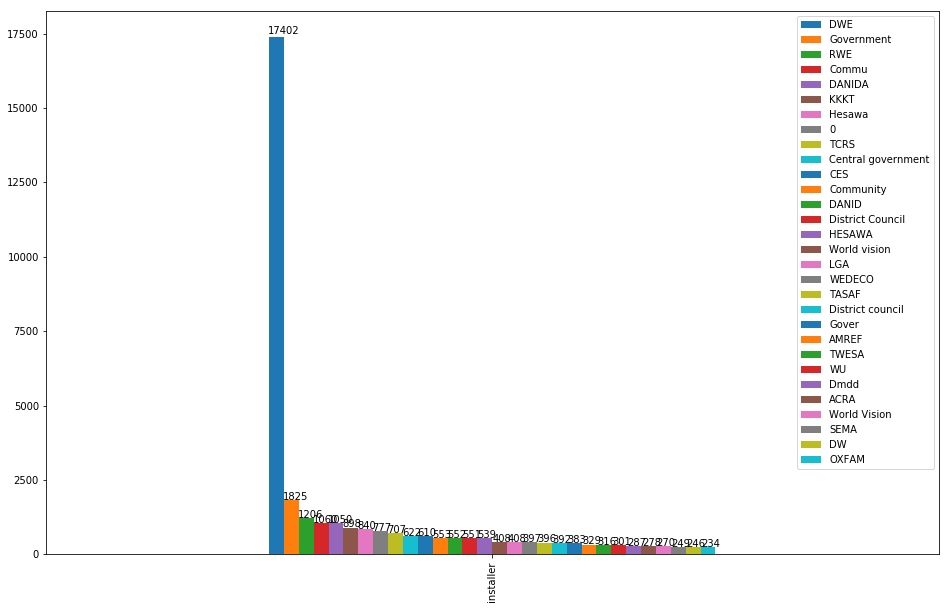

In [20]:
ax = install_30.T.plot(kind = 'bar' , figsize = (16, 10))
for p in ax.patches:
     ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

#####  *** Insight -1  ; funders and installers may or may not be same.

##### 3. wpt_name  - The name of the water points in the locality

In [21]:
wpt_30  = pd.DataFrame(train_data['wpt_name'].value_counts().head(30))

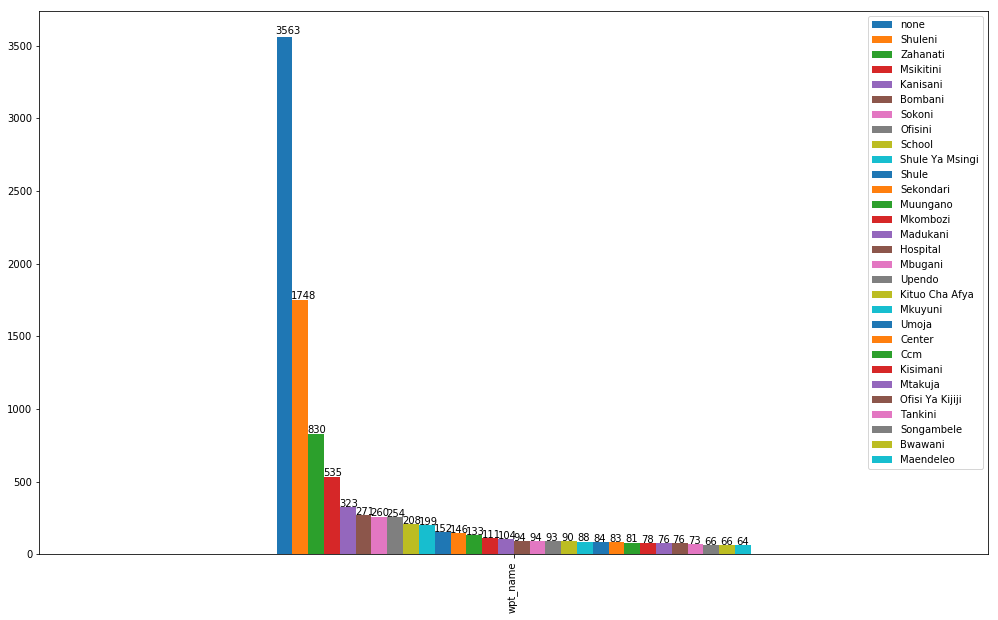

In [22]:
ax = wpt_30.T.plot(kind = 'bar' , figsize = (17, 10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### *** Insight -2  ; A good number of locations doesn't have water_points

##### 4. basin -  Geographical Water Basin

In [23]:
len(train_data['basin'].unique())

9

In [24]:
# checking if there are missing values for basin
train_data['basin'].isna().sum()

0

#####  *** Insight -3 .  There are 9 basins from where all the waters are supplied.

In [25]:
# Let's visualize , how basins compare in terms of supplying the water
basin_df = pd.DataFrame(train_data['basin'].value_counts())

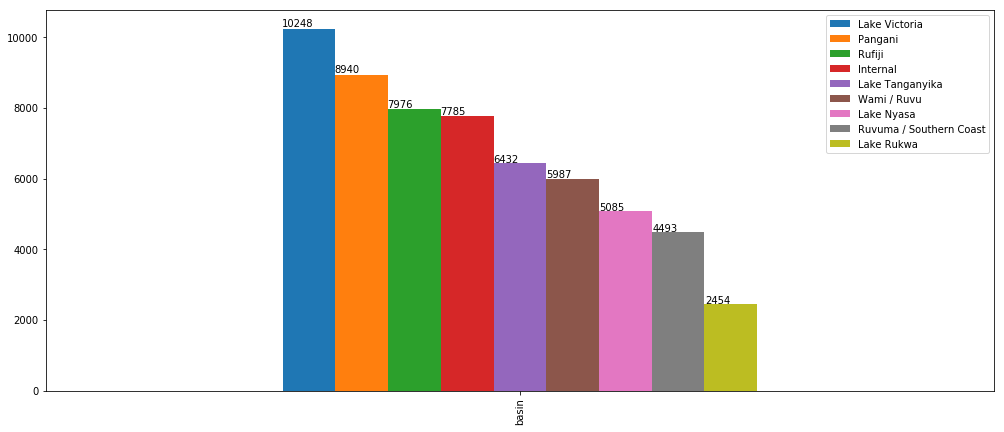

In [26]:
ax = basin_df.T.plot(kind = 'bar', figsize=(17,7))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 5. subvillage -  Geographical Region

In [27]:
#train_data['subvillage'].value_counts()

In [28]:
train_data['subvillage'].isna().sum()

371

In [29]:
len(train_data['subvillage'].unique())

19288

##### At this point there is an intuition that all the features related geographical distance has a bearance in terms of proximity to main-water-bidies(basins) , which are the source of supplies for these water-points.

'Lake Victoria' = Latitude: -1° 00' 0.00" S
Longitude: 33° 00' 0.00" E

'Pangani' = Latitude: -5° 25' 30.94" S
Longitude: 38° 58' 29.03" E

'Rufiji' = Latitude: -8° 00' 0.00" S
Longitude: 39° 19' 60.00" E

'Internal'(same as ruvu) = Latitude: -6° 48' 17.99" S
Longitude: 38° 41' 59.99" E

'Lake Tanganyika' = 6.2556° S, 29.5108° E

'Wami' - Latitude: -6° 07' 60.00" S
Longitude: 38° 48' 59.99" E

'Lake Nyasa' = 11.6701° S, 34.6857° E

'Ruvuma' = 10.6879° S, 36.2631° E

'Lake Rukwa' = 8.0167° S, 32.2654° E

In [30]:
train_data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

##### 6. region  - Geographic location (coded)

In [31]:
train_data['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [32]:
region_data = pd.DataFrame(train_data['region'].value_counts())

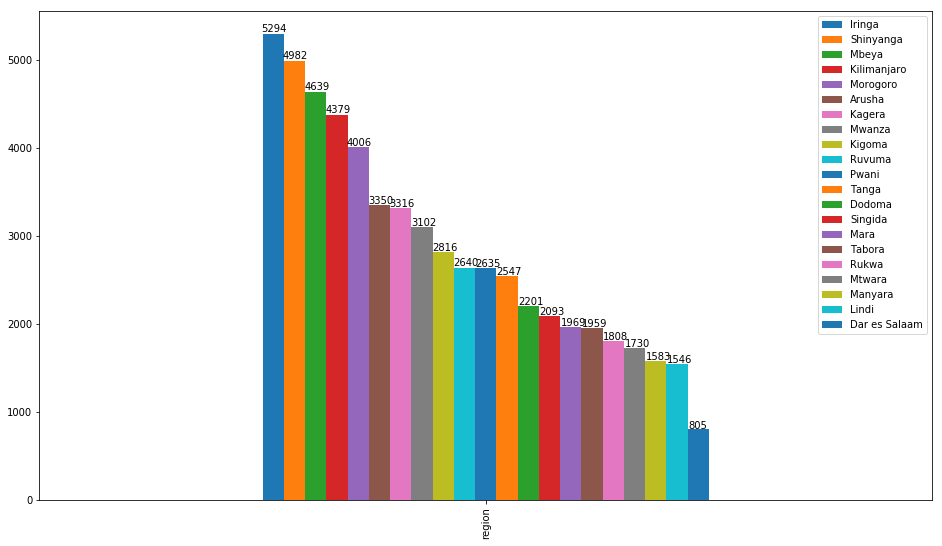

In [33]:
ax = region_data.T.plot(kind = 'bar', figsize= (16,9))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

##### 7.lga - Geographic location

In [34]:
print('Number of LGA in the dataset : ',len(train_data['lga'].unique()),
      ' and number of missing entries is ',train_data['lga'].isna().sum())

Number of LGA in the dataset :  125  and number of missing entries is  0


In [35]:
print('Number of regions in the dataset : ',len(train_data['region'].unique()),
     ' and number of missing entries is ',train_data['region'].isna().sum())

Number of regions in the dataset :  21  and number of missing entries is  0


###### *** Insight 4 - lga and region might be redundant informations for predictive modelling, for analysis and administrative view of which locations and their corresponding sub-locations has more issues

In [36]:
agg_reg_lga = train_data[['region','lga']].groupby('region').count()

Text(0, 0.5, ' Count of lga ')

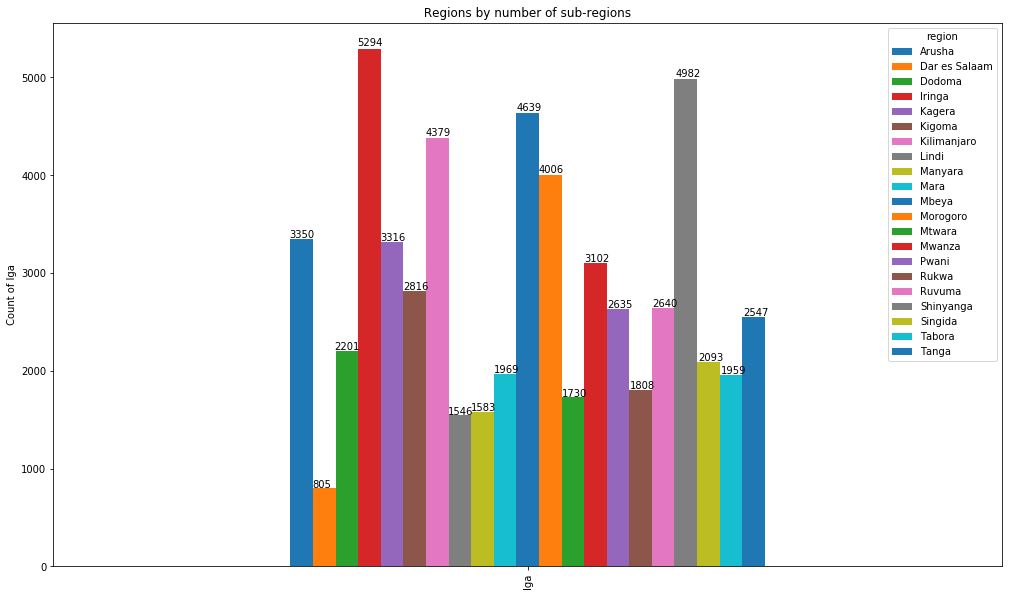

In [37]:
ax = agg_reg_lga.T.plot(kind = 'bar', figsize=(17, 10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title(' Regions by number of sub-regions ')
plt.ylabel(' Count of lga ')

##### 8. ward - Geographic location 

In [38]:
print('Number of wards in the dataset : ',len(train_data['ward'].unique()),
     ' and number of missing entries is ',train_data['ward'].isna().sum())

Number of wards in the dataset :  2092  and number of missing entries is  0


##### **** Insight - 5 So "ward" is the sub-category of the "lga" which is sub-category to "region"

In [39]:
location_df = train_data[['region','lga','ward']].groupby(['region','lga']).count()

In [40]:
location_df

ward
region        lga                   
Arusha        Arusha Rural      1252
              Arusha Urban        63
              Karatu             326
              Longido            310
              Meru              1009
              Monduli            189
              Ngorongoro         201
Dar es Salaam Ilala              497
              Kinondoni           93
              Temeke             215
Dodoma        Bahi               224
              Chamwino           347
              Dodoma Urban       358
              Kondoa             523
              Kongwa             361
              Mpwapwa            388
Iringa        Iringa Rural       728
              Kilolo             349
              Ludewa             564
              Makete             630
              Mufindi            520
              Njombe            2503
Kagera        Biharamulo         403
              Bukoba Rural       487
              Bukoba Urban        88
              Chato              236
              Karagwe            771
              Misenyi            260
              Muleba             402
              Ngara              669
Kigoma        Kasulu            1047
              Kibondo            874
              Kigoma Rural       824
              Kigoma Urban        71
Kilimanjaro   Hai                625
              Moshi Rural       1251
              Moshi Urban         79
              Mwanga             519
              Rombo              594
              Same               877
              Siha               434
Lindi         Kilwa              392
              Lindi Rural        388
              Lindi Urban         21
              Liwale             154
              Nachingwea         300
              Ruangwa            291
Manyara       Babati             511
              Hanang             274
              Kiteto             193
              Mbulu              297
              Simanjiro          308
Mara          Bunda              438
              Musoma Rural       396
              Rorya              210
              Serengeti          716
              Tarime             209
Mbeya         Chunya             298
              Ileje              231
              Kyela              859
              Mbarali            626
              Mbeya Rural        485
              Mbozi             1034
              Rungwe            1106
Morogoro      Kilombero          959
              Kilosa            1094
              Morogoro Rural     521
              Morogoro Urban      96
              Mvomero            671
              Ulanga             665
Mtwara        Masasi             528
              Mtwara Rural       423
              Mtwara Urban       124
              Nanyumbu           158
              Newala             231
              Tandahimba         266
Mwanza        Geita              488
              Ilemela            142
              Kwimba             627
              Magu               824
              Missungwi          348
              Nyamagana            1
              Sengerema          331
              Ukerewe            341
Pwani         Bagamoyo           997
              Kibaha             269
              Kisarawe           223
              Mafia              132
              Mkuranga           560
              Rufiji             454
Rukwa         Mpanda             679
              Nkasi              428
              Sumbawanga Rural   521
              Sumbawanga Urban   180
Ruvuma        Mbinga             750
              Namtumbo           694
              Songea Rural       693
              Songea Urban        80
              Tunduru            423
Shinyanga     Bariadi           1177
              Bukombe            514
              Kahama             836
              Kishapu            399
              Maswa              809
              Meatu              468
              Shinyanga Rural    588
              Shinyanga Urban    191

#### 9. public_meeting - True/False

In [41]:
train_data['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

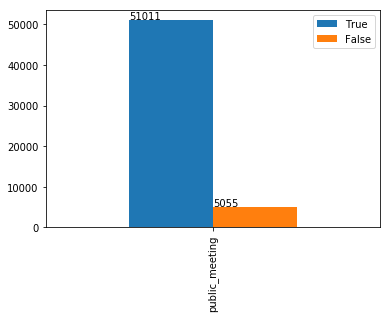

In [42]:
ax = pd.DataFrame(train_data['public_meeting'].value_counts()).T.plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))

##### 10. recorded_by - Group entering this row of data

In [43]:
train_data['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

#### **** All the data was recorded by "GeoData Consultants Ltd"  

#### This info may be left out while model creation as there isn't anything a recorder can do to make prediction of the pumps condition.

##### 11. scheme_management - Who operates the waterpoint

In [44]:
scheme_mgmt = pd.DataFrame(train_data['scheme_management'].value_counts())

Text(0.5, 0, ' Scheme Management')

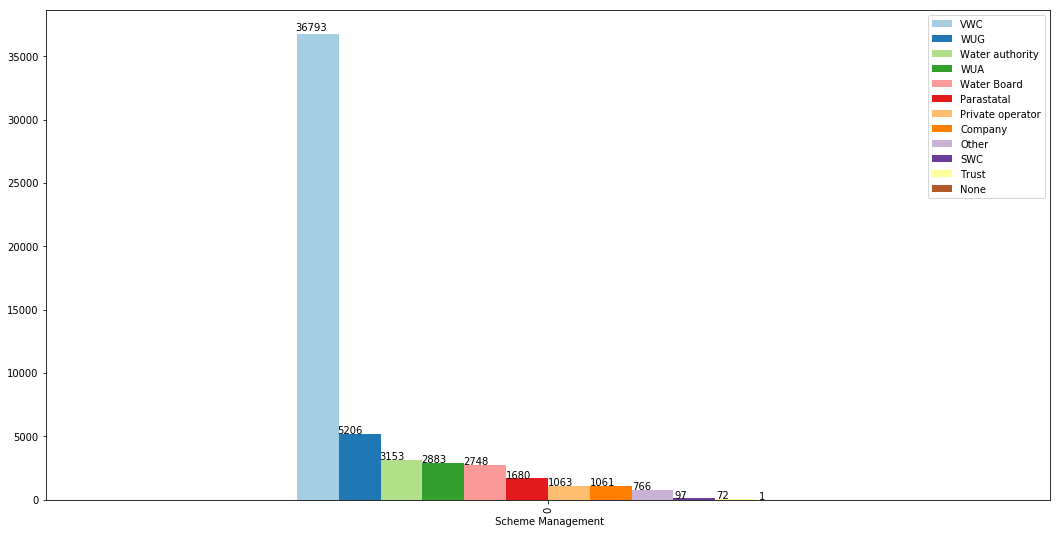

In [45]:
ax = scheme_mgmt.T.plot(kind = 'bar', figsize=(18,9) , colormap = 'Paired', use_index= False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Scheme Management')

In [46]:
train_data['scheme_management'].isna().sum()

3877

#### 12. scheme_name - Who operates the waterpoint

##### scheme_name is name of the scheme manged by a particular scheme_management . It would be interesting to see who manages how many . Depending on who manges , model can eschew the pattern of mangement related to pump condition.    
##### Hence, the above figure .  The scheme_management is useful and scheme_name becomes redundant info.

#### 13. permit - If the waterpoint is permitted

In [47]:
permit_df = pd.DataFrame(train_data['permit'].value_counts())

Text(0.5, 0, ' Permit')

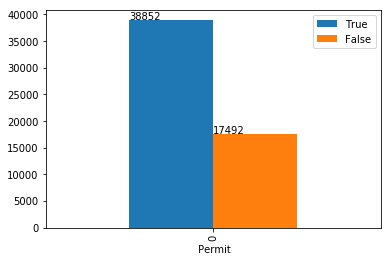

In [48]:
ax = permit_df.T.plot(kind = 'bar', use_index = False )
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Permit')

##### *** Insight 6 - A huge number of pumps , nearly a third are without permit.

#### 14. extraction_type - The kind of extraction the waterpoint uses

In [49]:
extract_df = pd.DataFrame(train_data['extraction_type'].value_counts())

Text(0.5, 0, ' Extraction Type')

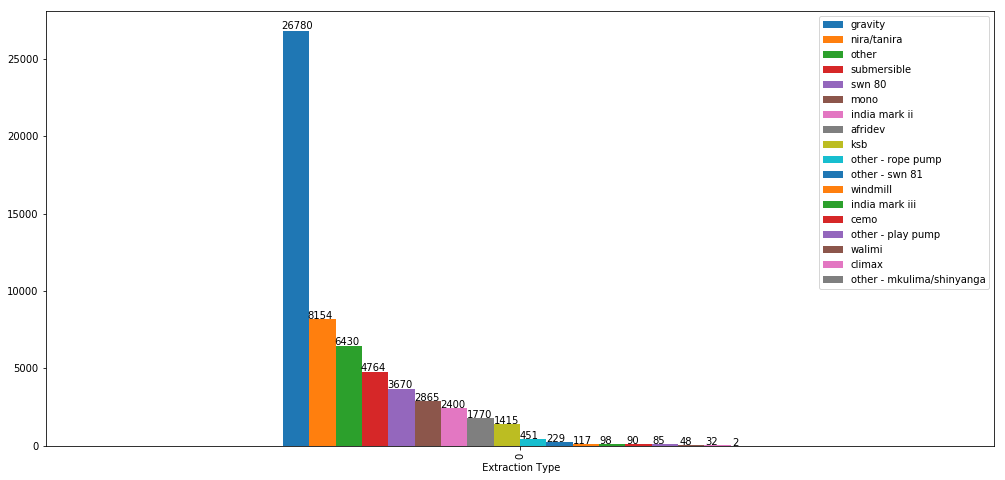

In [50]:
ax = extract_df.T.plot(kind = 'bar', figsize=(17, 8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Extraction Type')

##### *** Insight 7 - The highest , about 50 percent of the pumps use gravity as extraction_type.

#### 15. extraction_type_group - The kind of extraction the waterpoint uses

In [51]:
train_data['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [52]:
train_data['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [53]:
train_data['extraction_type_group'].isna().sum()

0

In [54]:
train_data['extraction_type'].isna().sum()

0

###### Both "extraction_type_group" and "extraction_type" are all but same , hence we can use either and drop the other for  predictive modelling.

#### 16. extraction_type_class - The kind of extraction the waterpoint uses

In [55]:
train_data['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [56]:
train_data['extraction_type_class'].isna().sum()

0

#### 17. management - How the waterpoint is managed

In [57]:
mgmt_df = pd.DataFrame(train_data['management'].value_counts())

Text(0.5, 0, ' Management')

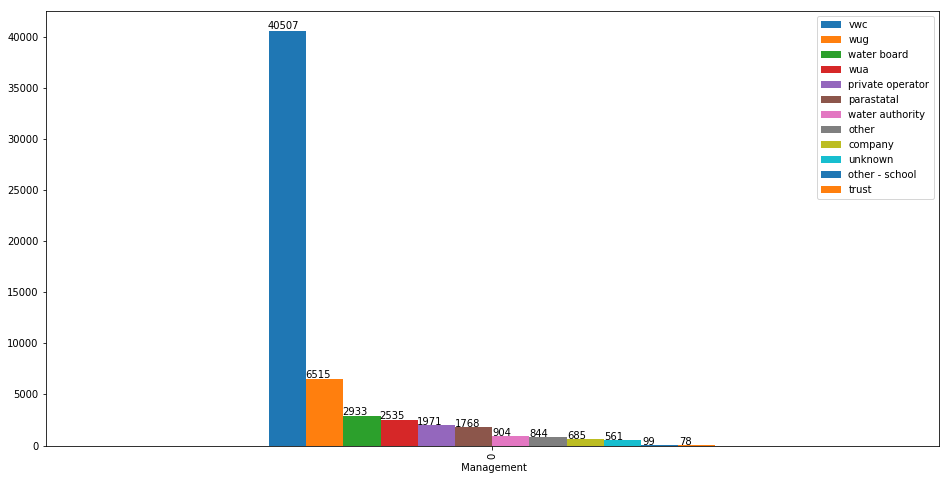

In [58]:
ax = mgmt_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Management')

#### 18. management_group - How the waterpoint is managed

In [59]:
mgmt_grp_df = pd.DataFrame(train_data['management_group'].value_counts())

Text(0.5, 0, ' Management Group')

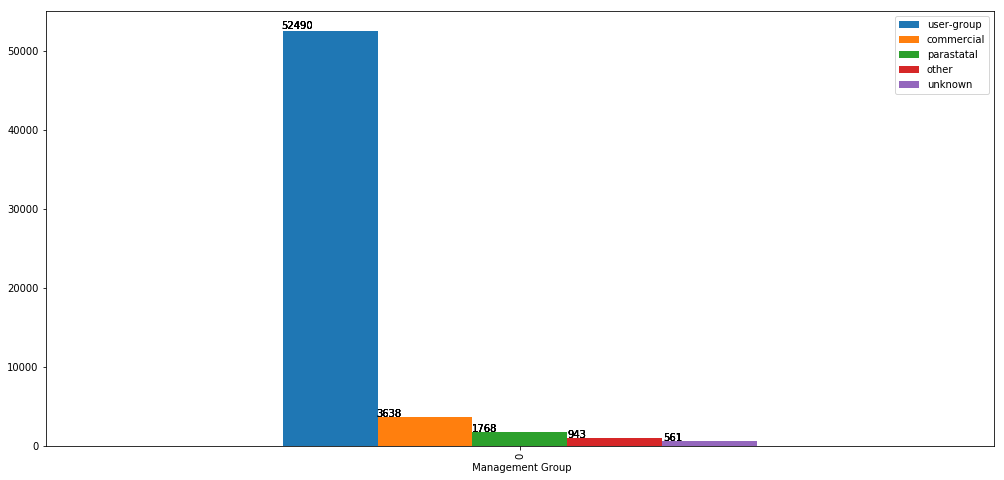

In [60]:
ax = mgmt_grp_df.T.plot(kind = 'bar', figsize=(17, 8), use_index=False)
for p in ax.patches:
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Management Group')

#### 19. payment - What the water costs

In [61]:
pay_df = pd.DataFrame(train_data['payment'].value_counts())

Text(0.5, 0, ' Payment')

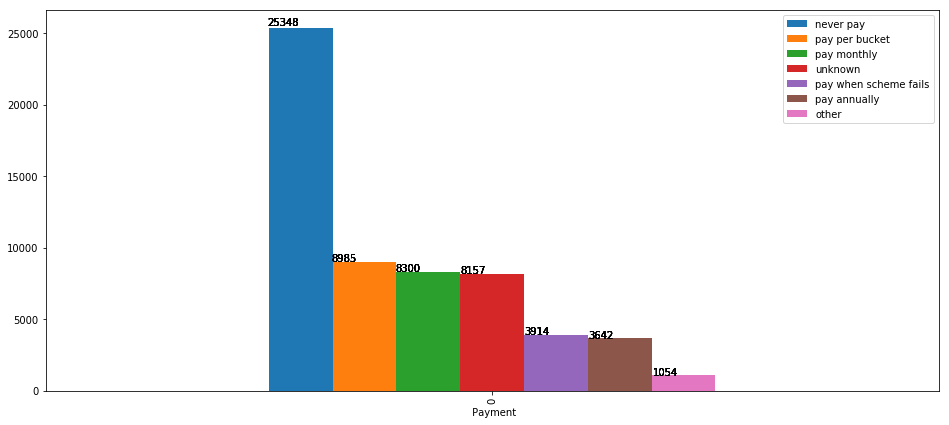

In [62]:
ax = pay_df.T.plot(kind = 'bar', figsize=(16, 7), use_index=False)
for p in ax.patches:
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Payment')

###### *** Insight 8 -  There are huge no-payments , gives the intuitions of what maintenance would have been done.

#### 20. payment_type - What the water costs

In [63]:
train_data['payment_type'].value_counts() 

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [64]:
train_data['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

#### "Payment_type" and "Payment" are duplicate , hence one has to dropped while modelling.

#### 21. water_quality - The quality of the water

In [65]:
wtr_qlt_df = pd.DataFrame(train_data['water_quality'].value_counts())

Text(0.5, 0, ' Water Quality ')

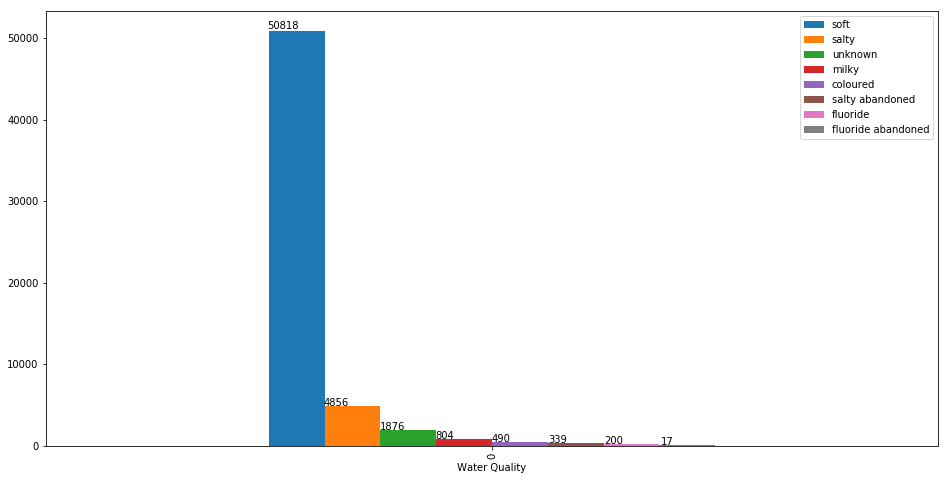

In [66]:
ax = wtr_qlt_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Water Quality ')

##### *** Insight 9  - Most of the water are soft .

#### 22. quality_group - The quality of the water

In [67]:
qlt_grp_df = pd.DataFrame(train_data['quality_group'].value_counts())

Text(0.5, 0, ' Quality Group ')

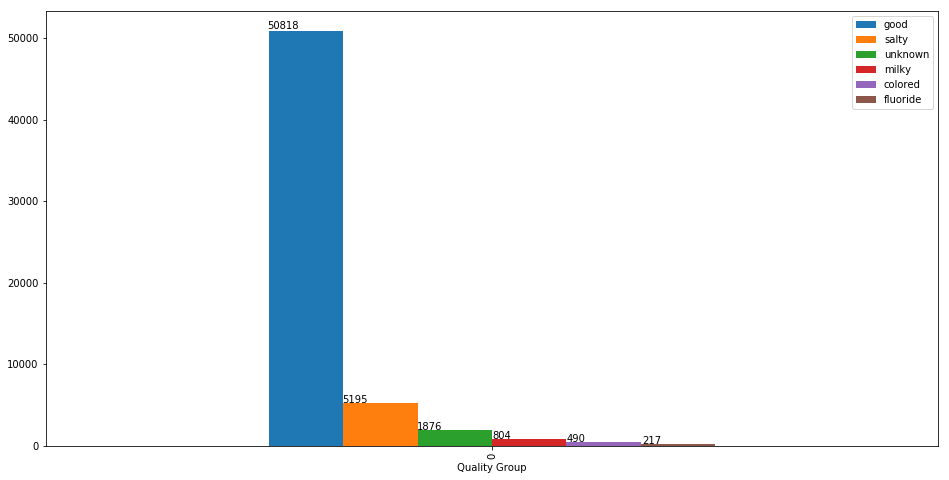

In [68]:
ax = qlt_grp_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Quality Group ')

#### "water_quality" and "quality_group" apparently from the above 2 figures look same/redundant , hence one can drop either one while modelling.

#### 23. quantity - The quantity of water

In [69]:
train_data['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

#### 24. quantity_group - The quantity of water

In [70]:
train_data['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

##### "quantity" and "quantity_group" are redundant hence , one can drop either and just use one for modelling. 

#### 25. source - The source of the water

In [71]:
train_data['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

#### 26. source_type - The source of the water

In [72]:
train_data['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

##### 'Source_type' looks redundant to "source" hence , while modelling one can drop "source_type".

#### 27. source_class - The source of the water

In [73]:
src_cls_df = pd.DataFrame(train_data['source_class'].value_counts())

Text(0.5, 0, ' Source Class ')

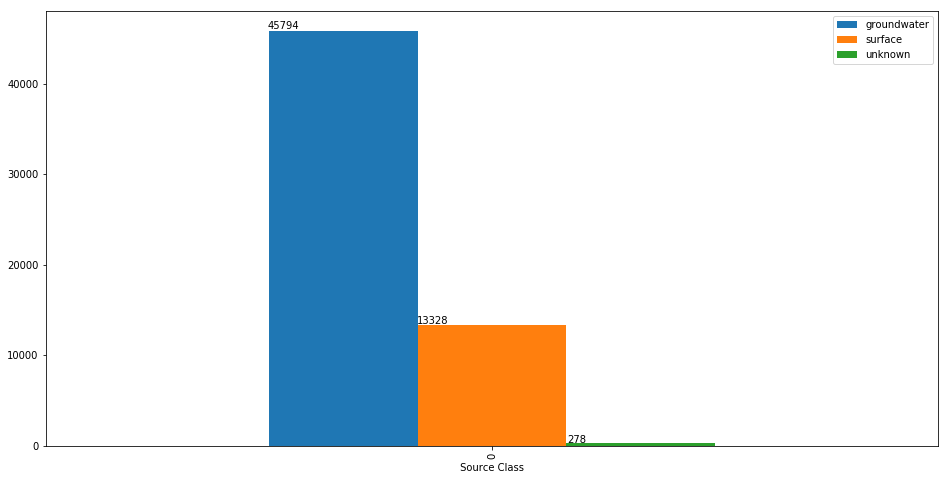

In [74]:
ax = src_cls_df.T.plot(kind = 'bar', figsize=(16,8), use_index=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Source Class ')

#### 28. waterpoint_type - The kind of waterpoint

In [75]:
train_data['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

#### 29 . waterpoint_type_group - The kind of waterpoint

In [76]:
train_data['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

##### "waterpoint_type" and "waterpoint_type_group" are redundant and either one can be dropped while modelling.

#### Let's visualize and analyze each of the numerical features for more insights .

In [77]:
[col for col in train_data.columns if train_data[col].dtypes in ('int64','float64')]

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

#### 1. Id is just id , hence ignore it 

#### 2. amount_tsh - Total static head (amount water available to waterpoint)

In [78]:
tsh_df = train_data[train_data['amount_tsh']  != 0]['amount_tsh']

In [79]:
len(tsh_df)

17761

In [80]:
len(train_data[train_data['amount_tsh'] == 0])

41639

(0, 10000)

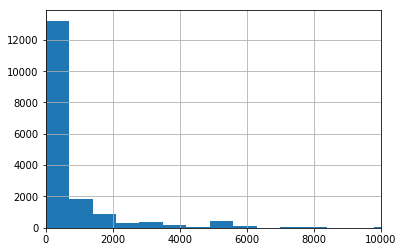

In [81]:
tsh_df.hist(bins = 500)
plt.xlim([0, 10000])

##### 'Total static head' feature is higly skewd(right) with 41693 (70% of records) equal to zero. Hence this has to be imputated using some technique (mean or median).

#### 3. gps_height - Altitude of the well

In [82]:
train_data['gps_height'].isna().sum()

0

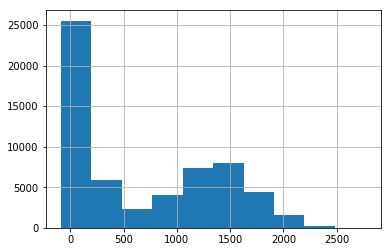

In [83]:
train_data['gps_height'].hist(bins = 10)

##### *** Insight 10 - The "gps height" is also skewed , meaning that wells are generally built at a certain heigh in Tanzania.

#### 4. longitude - GPS coordinate .  This will be dealt separately , as it will be used to calculate the distance from the basin.

#### 5. latitude - GPS coordinate. This will be dealt separately , as it will be used to calculate the distance from the basin.

#### 6. num_private - The info is completely missing hence nothing can be said or hypothesissed.

#### 7. region_code - Geographic location (coded) -  Locations are important to determine the proximity to the main water bodies , but we will use gps coordinates for the same.

#### 8. district_code - Geographic location (coded) - Locations are important to determine the proximity to the main water bodies , but we will use gps coordinates for the same.

#### 9. population - population - Population around the well 

In [84]:
train_data['population'].isna().sum()

0

(0, 3000)

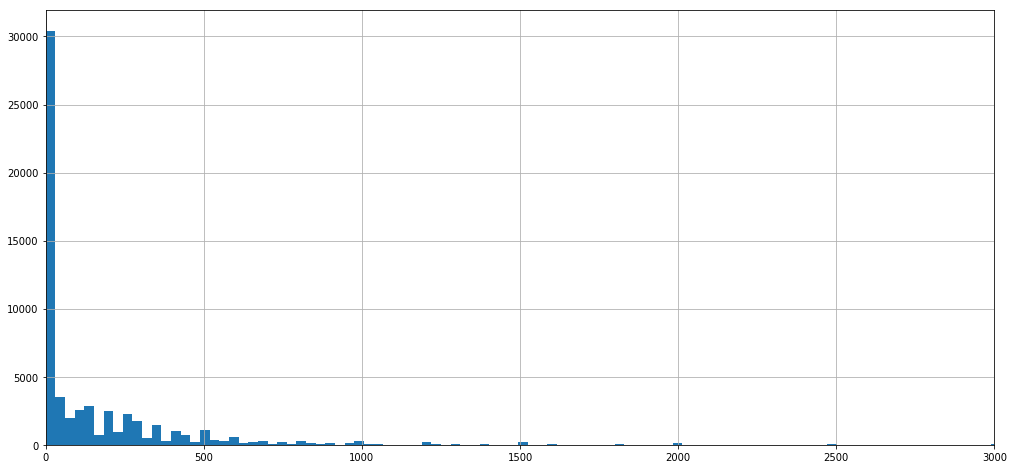

In [85]:
plt.figure(figsize=(17,8))
train_data['population'].hist(bins = 1000)
plt.xlim([0, 3000])


In [86]:
train_data['population'].max()

30500

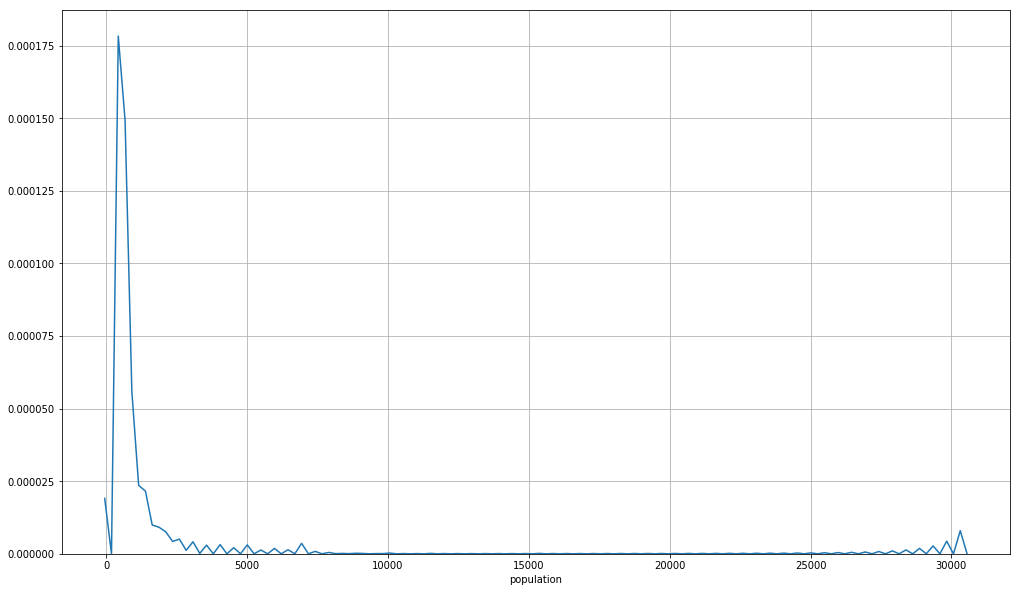

In [87]:
plt.figure(figsize=(17,10))
plt.grid(True)
sns.distplot(train_data['population'] , bins = 500, hist = False)


#### Lets' visualize and analyse the date columns

In [88]:
[col for col in train_data.columns if train_data[col].dtype == 'datetime64[ns]']

['date_recorded']

##### 1. date_recorded - The date the row was entered

In [89]:
train_data['date_recorded'].head()

0   2011-03-14
1   2013-03-06
2   2013-02-25
3   2013-01-28
4   2011-07-13
Name: date_recorded, dtype: datetime64[ns]

In [90]:
year_f = lambda x: x.year

In [91]:
train_data['year_recorded'] = train_data['date_recorded'].apply(year_f)

In [92]:
train_data[['date_recorded','year_recorded']].head()

date_recorded  year_recorded
0    2011-03-14           2011
1    2013-03-06           2013
2    2013-02-25           2013
3    2013-01-28           2013
4    2011-07-13           2011

In [93]:
year_rcrd = train_data['year_recorded'].astype('str')

In [94]:
year_rcrd = year_rcrd.value_counts()

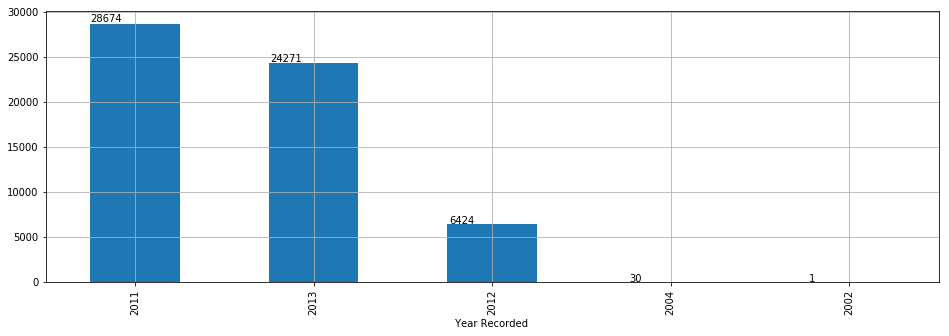

In [95]:
ax = year_rcrd.plot(kind = 'bar' , figsize=(16, 5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Year Recorded ')
plt.grid(True)

In [96]:
train_data['month_recorded'] = train_data['date_recorded'].apply(lambda x: x.month)

In [97]:
train_data[['date_recorded','month_recorded']].head()

date_recorded  month_recorded
0    2011-03-14               3
1    2013-03-06               3
2    2013-02-25               2
3    2013-01-28               1
4    2011-07-13               7

In [98]:
month_rcrd = train_data['month_recorded'].astype('str')

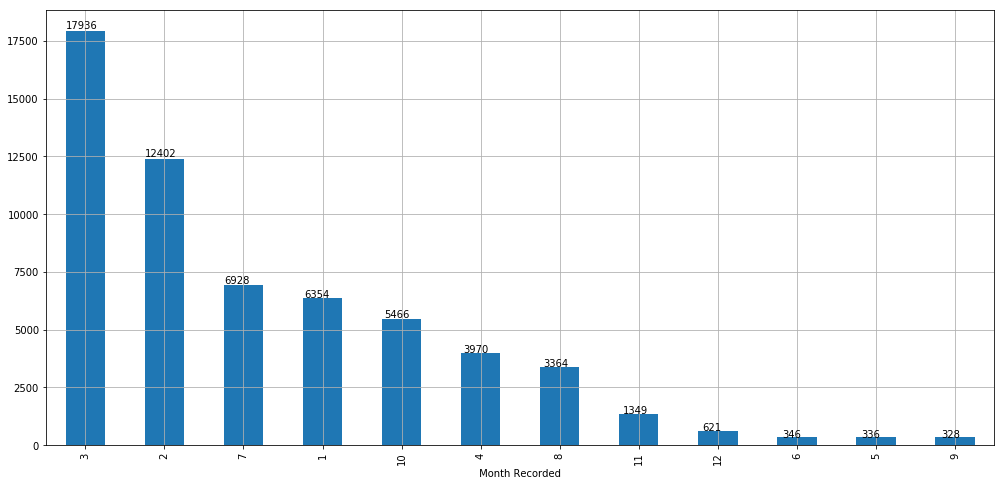

In [99]:
ax = month_rcrd.value_counts().plot(kind = 'bar', figsize=(17, 8))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.007, p.get_height() * 1.007))
plt.xlabel(' Month Recorded ')
plt.grid(True)

##### *** Insight 11 - FEB and MARCH are the month where most surveys are conducted followed by july , jan and october. Mid year has very few surveys.  Perhaps , survey should be distributed equally throughout the year , so that status of pumps are noticed before it's too late .

#### 2. construction_year - Year the waterpoint was constructed

In [100]:
train_data['construction_year'].isna().sum()

0

In [101]:
train_data[['date_recorded','construction_year','year_recorded']].head()

date_recorded  construction_year  year_recorded
0    2011-03-14               1999           2011
1    2013-03-06               2010           2013
2    2013-02-25               2009           2013
3    2013-01-28               1986           2013
4    2011-07-13                  0           2011

In [102]:
train_data['years_elapsed'] = train_data['year_recorded'] - train_data['construction_year']

In [103]:
train_data[['date_recorded','construction_year','year_recorded','years_elapsed']].head()

date_recorded  construction_year  year_recorded  years_elapsed
0    2011-03-14               1999           2011             12
1    2013-03-06               2010           2013              3
2    2013-02-25               2009           2013              4
3    2013-01-28               1986           2013             27
4    2011-07-13                  0           2011           2011

In [104]:
len(train_data[train_data['construction_year'] == 0])

20709

###### Since a quite a huge number of records are without the year of construction , the intuition here is to replace/impute this with the mode of the fetaure sans zero.

##### Thus , we can engineer a new feature that gives the life of the pumps.

In [105]:
from scipy.stats import mode
mode(train_data[train_data['construction_year'] != 0]['construction_year'])

ModeResult(mode=array([2010], dtype=int64), count=array([2645]))

##### Mode of the construction_year is 2010

In [106]:
train_data['const_yr_impt_2010'] = np.where(train_data['construction_year'] == 0, 2010, train_data['construction_year'])

In [107]:
train_data['const_yr_impt_2010'].head()

0    1999
1    2010
2    2009
3    1986
4    2010
Name: const_yr_impt_2010, dtype: int64

In [108]:
train_data['years_elapsed'] = train_data['year_recorded'] - train_data['const_yr_impt_2010']

In [109]:
train_data[['date_recorded','construction_year','const_yr_impt_2010','year_recorded','years_elapsed']].head()

date_recorded  construction_year  const_yr_impt_2010  year_recorded  \
0    2011-03-14               1999                1999           2011   
1    2013-03-06               2010                2010           2013   
2    2013-02-25               2009                2009           2013   
3    2013-01-28               1986                1986           2013   
4    2011-07-13                  0                2010           2011   

   years_elapsed  
0             12  
1              3  
2              4  
3             27  
4              1

In [110]:
train_data.head(10)

id  amount_tsh date_recorded               funder  gps_height  \
0  69572      6000.0    2011-03-14                Roman        1390   
1   8776         0.0    2013-03-06              Grumeti        1399   
2  34310        25.0    2013-02-25         Lottery Club         686   
3  67743         0.0    2013-01-28               Unicef         263   
4  19728         0.0    2011-07-13          Action In A           0   
5   9944        20.0    2011-03-13  Mkinga Distric Coun           0   
6  19816         0.0    2012-10-01                 Dwsp           0   
7  54551         0.0    2012-10-09                Rwssp           0   
8  53934         0.0    2012-11-03             Wateraid           0   
9  46144         0.0    2011-08-03          Isingiro Ho           0   

      installer  longitude   latitude              wpt_name  num_private  \
0         Roman  34.938093  -9.856322                  none            0   
1       GRUMETI  34.698766  -2.147466              Zahanati            0   
2  World vision  37.460664  -3.821329           Kwa Mahundi            0   
3        UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4       Artisan  31.130847  -1.825359               Shuleni            0   
5           DWE  39.172796  -4.765587                Tajiri            0   
6          DWSP  33.362410  -3.766365            Kwa Ngomho            0   
7           DWE  32.620617  -4.226198          Tushirikiane            0   
8     Water Aid  32.711100  -5.146712     Kwa Ramadhan Musa            0   
9       Artisan  30.626991  -1.257051               Kwapeto            0   

                     basin       subvillage     region  region_code  \
0               Lake Nyasa         Mnyusi B     Iringa           11   
1            Lake Victoria          Nyamara       Mara           20   
2                  Pangani          Majengo    Manyara           21   
3  Ruvuma / Southern Coast       Mahakamani     Mtwara           90   
4            Lake Victoria       Kyanyamisa     Kagera           18   
5                  Pangani      Moa/Mwereme      Tanga            4   
6                 Internal    Ishinabulandi  Shinyanga           17   
7          Lake Tanganyika  Nyawishi Center  Shinyanga           17   
8          Lake Tanganyika       Imalauduki     Tabora           14   
9            Lake Victoria         Mkonomre     Kagera           18   

   district_code              lga        ward  population public_meeting  \
0              5           Ludewa    Mundindi         109           True   
1              2        Serengeti       Natta         280            NaN   
2              4        Simanjiro     Ngorika         250           True   
3             63         Nanyumbu    Nanyumbu          58           True   
4              1          Karagwe  Nyakasimbi           0           True   
5              8           Mkinga         Moa           1           True   
6              3  Shinyanga Rural      Samuye           0           True   
7              3           Kahama      Chambo           0           True   
8              6     Tabora Urban    Itetemia           0           True   
9              1          Karagwe      Kaisho           0           True   

               recorded_by scheme_management                  scheme_name  \
0  GeoData Consultants Ltd               VWC                        Roman   
1  GeoData Consultants Ltd             Other                          NaN   
2  GeoData Consultants Ltd               VWC  Nyumba ya mungu pipe scheme   
3  GeoData Consultants Ltd               VWC                          NaN   
4  GeoData Consultants Ltd               NaN                          NaN   
5  GeoData Consultants Ltd               VWC                    Zingibali   
6  GeoData Consultants Ltd               VWC                          NaN   
7  GeoData Consultants Ltd               NaN                          NaN   
8  GeoData Consultants Ltd               VWC                          NaN  

In [111]:
#### 34.93809275	-9.85632177  
#### Lake Nysa - 11.6701° S, 34.6857° E

In [112]:
train_data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [113]:
# function to convert degree, minutes , seconds to just to degree .
def conv_degree(lat):
    lat = lat.replace(" ","")
    deg, minutes, seconds, direction =  re.split('[°\'"]', lat)
    return (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

In [114]:
# 'Lake Victoria' = Latitude: -1° 00' 0.00" S Longitude: 33° 00' 0.00" E
lat_1 = conv_degree("""-1° 00' 0.00" S""")
log_1 = conv_degree("""33° 00' 0.00" E""")

# 'Pangani' = Latitude: -5° 25' 30.94" S Longitude: 38° 58' 29.03" E
lat_2 = conv_degree("""-5° 25' 30.94" S""")
log_2 = conv_degree("""38° 58' 29.03" E""")

# 'Rufiji' = Latitude: -8° 00' 0.00" S Longitude: 39° 19' 60.00" E
lat_3 = conv_degree("""-8° 00' 0.00" S""")
log_3 = conv_degree("""39° 19' 60.00" E""")

# 'Internal'(same as ruvu) = Latitude: -6° 48' 17.99" S Longitude: 38° 41' 59.99" E
lat_4 = conv_degree("""-6° 48' 17.99" S""")
log_4 = conv_degree("""38° 41' 59.99" E""")

# 'Lake Tanganyika' = 6.2556° S, 29.5108° E
lat_5 = conv_degree("""6.2556° 0' 00" S""")
log_5 = conv_degree("""29.5108° 0' 00" E""")

# 'Wami / Ruvu' - Latitude: -6° 07' 60.00" S Longitude: 38° 48' 59.99" E
lat_6 = conv_degree("""-6° 07' 60.00" S""")
log_6 = conv_degree("""38° 48' 59.99" E""")

# 'Lake Nyasa' = 11.6701° S, 34.6857° E
lat_7 = conv_degree("""11.6701° 0' 00" S""")
log_7 = conv_degree("""34.6857° 0' 00" E""")

# 'Ruvuma / Southern Coast' = 10.6879° S, 36.2631° E
lat_8 = conv_degree("""10.6879° 0' 00" S""")
log_8 = conv_degree("""36.2631° 0' 00" E""")

#'Lake Rukwa' = 8.0167° S, 32.2654° E
lat_9 = conv_degree("""8.0167° 0' 00" S""")
log_9 = conv_degree("""32.2654° 0' 00" E""")

In [115]:
def get_basin_lat_long(basin , lat_or_long):
    if basin == "Lake Victoria":
        latitude = lat_1
        longitude = log_1
    elif basin == "Pangani":
        latitude = lat_2
        longitude = log_2
    elif basin == "Rufiji":
        latitude = lat_3
        longitude = log_3
    elif basin == "Internal":
        latitude = lat_4
        longitude = log_4
    elif basin == "Lake Tanganyika":
        latitude = lat_5
        longitude = log_5
    elif basin == "Wami / Ruvu":
        latitude = lat_6
        longitude = log_6
    elif basin == "Lake Nyasa":
        latitude = lat_7
        longitude = log_7
    elif basin == "Ruvuma / Southern Coast":
        latitude = lat_8
        longitude = log_8
    elif basin == "Lake Rukwa":
        latitude = lat_9
        longitude = log_9
    
    if lat_or_long.lower() == 'latitude':
        return latitude
    elif lat_or_long.lower() == 'longitude':
        return longitude
        
        

In [116]:
get_basin_lat_long("Lake Tanganyika", 'latitude')

-6.2556

In [117]:
train_data['basin_latitude'] = train_data['basin'].apply(get_basin_lat_long, lat_or_long = 'latitude')

In [118]:
train_data['basin_longitude'] = train_data['basin'].apply(get_basin_lat_long, lat_or_long = 'longitude')

In [119]:
# function to calculate the distance of pumps from the respective basins in KMs
def dist_from_basin(basin_lat, basin_long, pump_lat, pump_long):
    coords_1 = (basin_lat.astype('float64'), basin_long.astype('float64'))
    coords_2 = (pump_lat.astype('float64'), pump_long.astype('float64'))
    
    return geopy.distance.vincenty(coords_1, coords_2).km


In [120]:
dist_list = []
for index, row in train_data[['basin_latitude','basin_longitude','latitude','longitude']].iterrows():
    dist = dist_from_basin(row['basin_latitude'], row['basin_longitude'], row['latitude'], row['longitude'])
    dist_list.append(dist)
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [121]:
len(dist_list)

59400

In [122]:
train_data['basin_pump_dist'] = pd.DataFrame({'basin_pump_dist':dist_list})

In [123]:
train_data[['basin_latitude','basin_longitude','latitude','longitude','basin_pump_dist']].head()

basin_latitude  basin_longitude   latitude  longitude  basin_pump_dist
0      -11.670100        34.685700  -9.856322  34.938093       202.517704
1        1.000000        33.000000  -2.147466  34.698766       396.072413
2        4.574739        38.974731  -3.821329  37.460664       943.553742
3      -10.687900        36.263100 -11.155298  38.486161       248.454311
4        1.000000        33.000000  -1.825359  31.130847       375.346864

In [124]:
train_data['basin_pump_dist'].isna().sum()

0

#### Let's visualize the collinearity among the numerical features

In [125]:
num_features = [col for col in train_data.columns if train_data[col].dtype in ('int64', 'float64')]

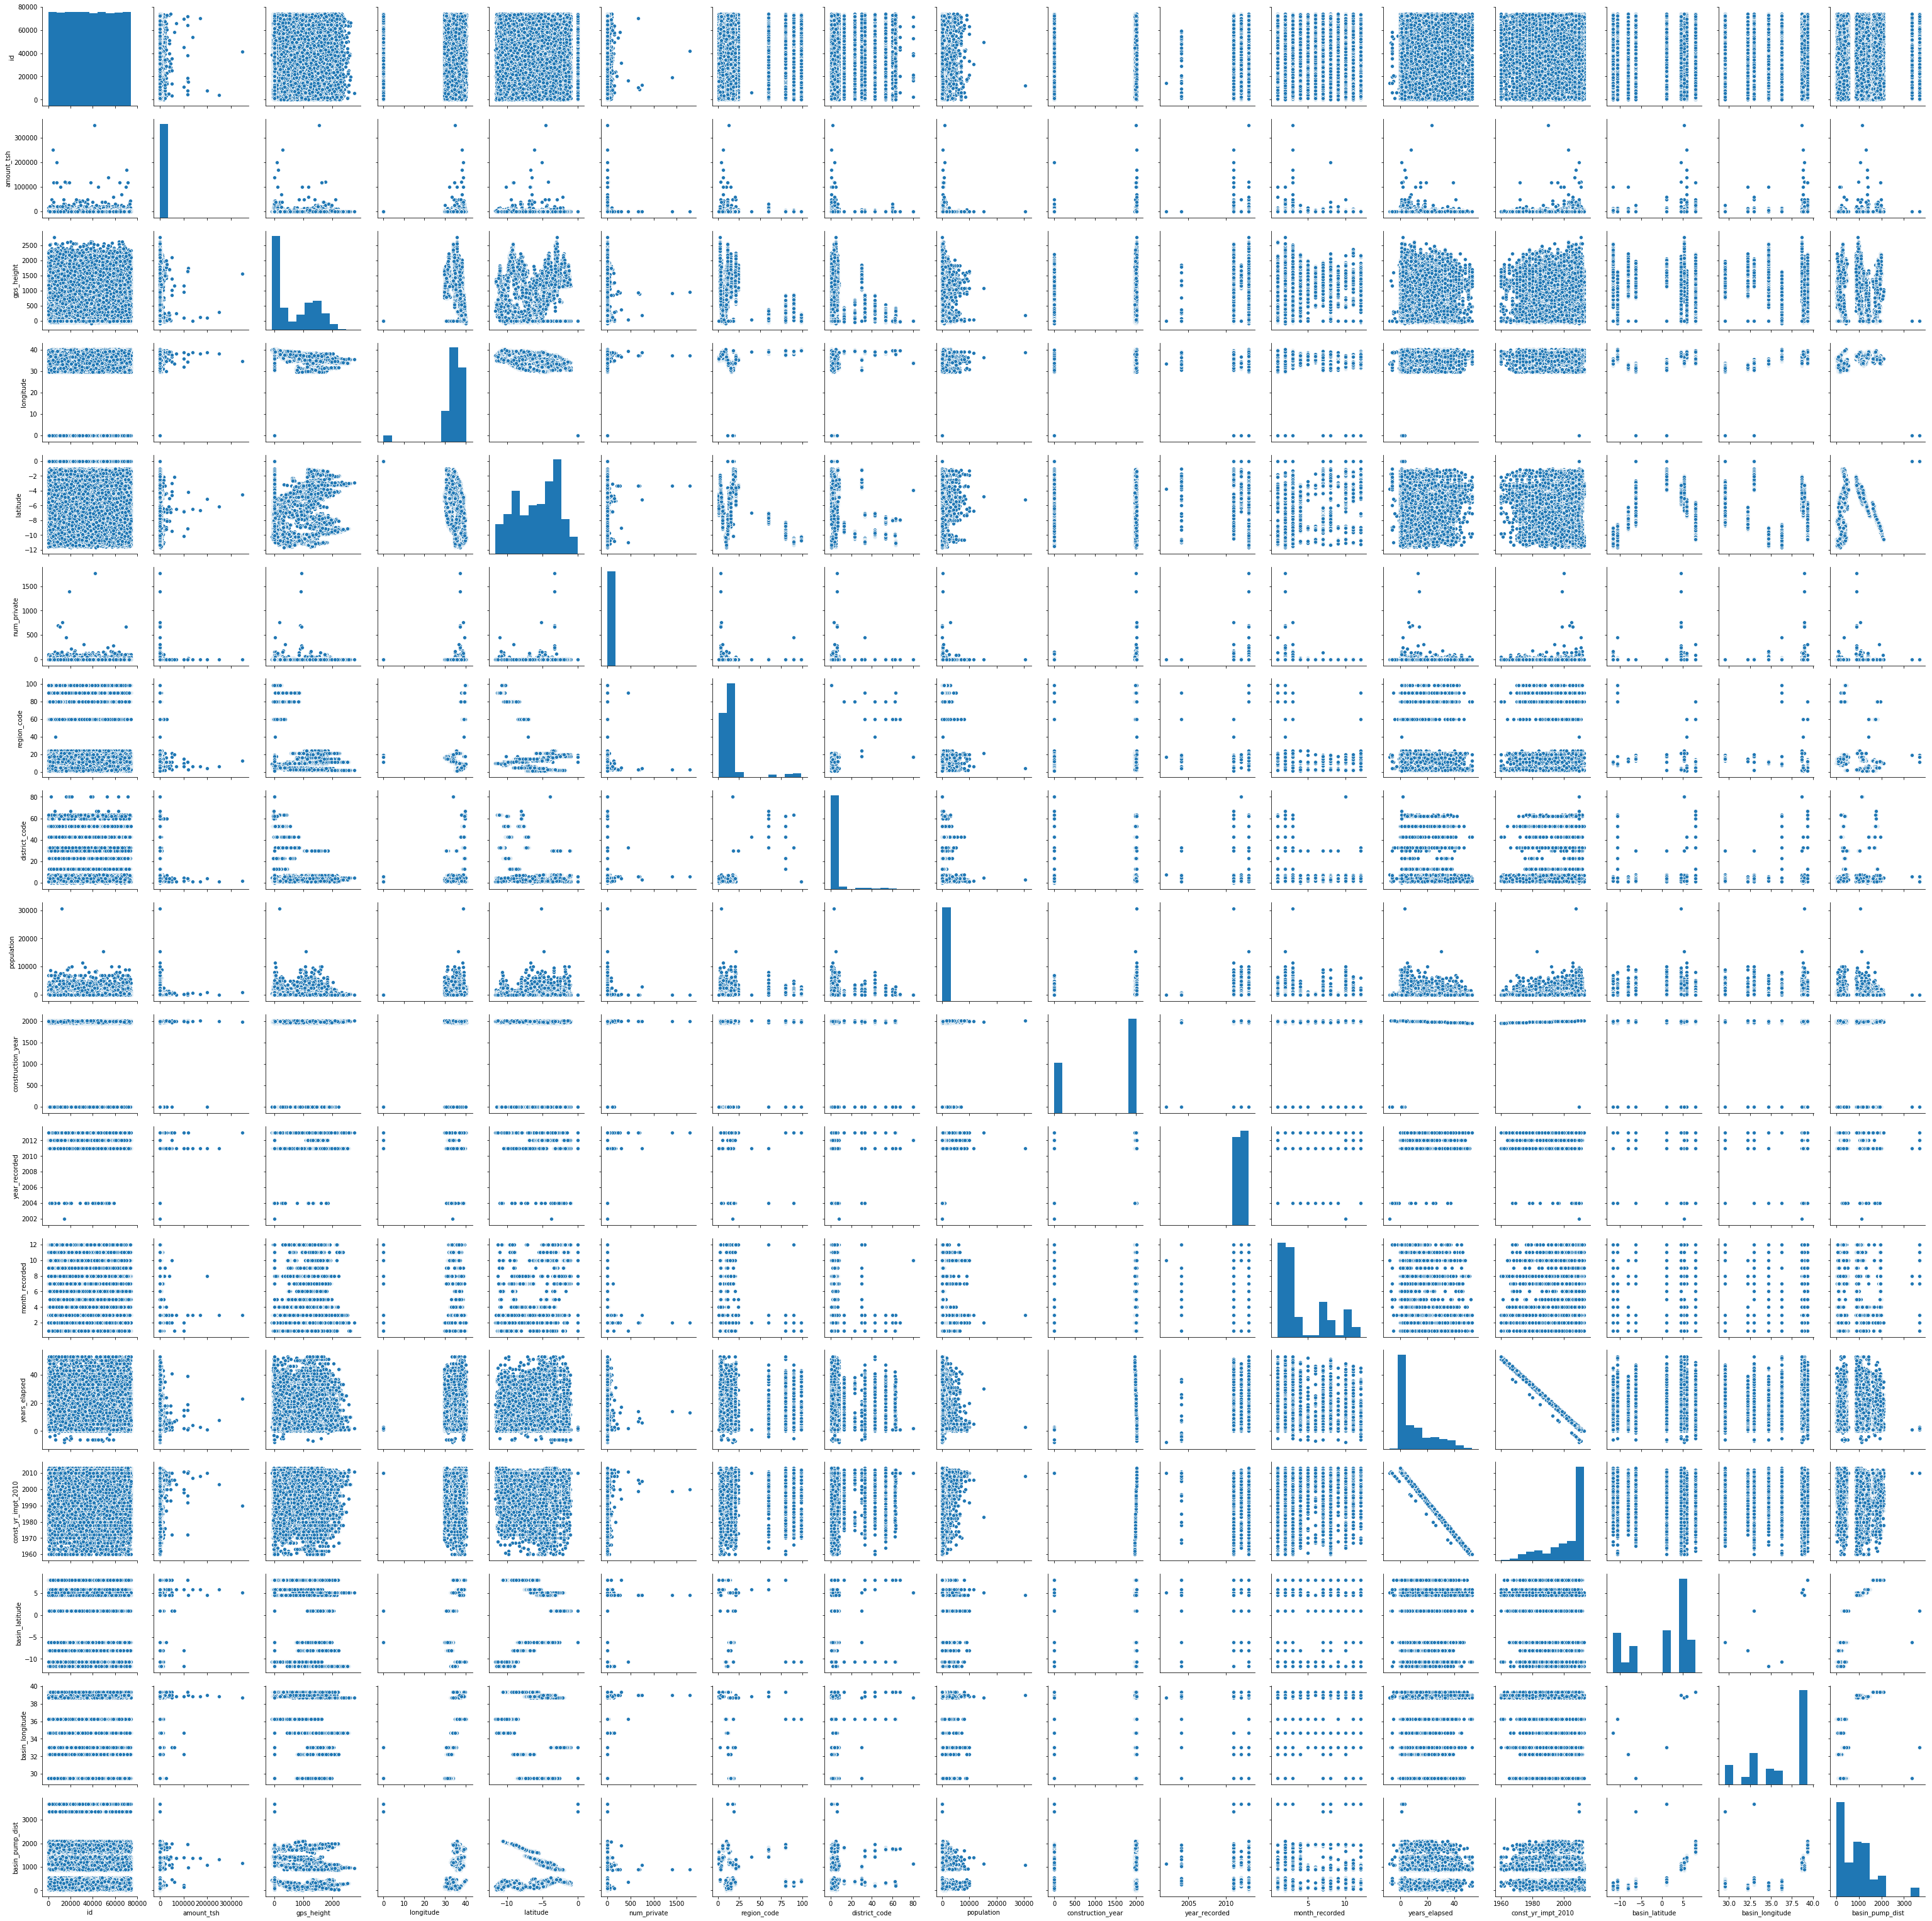

In [126]:
sns.pairplot(train_data[num_features])

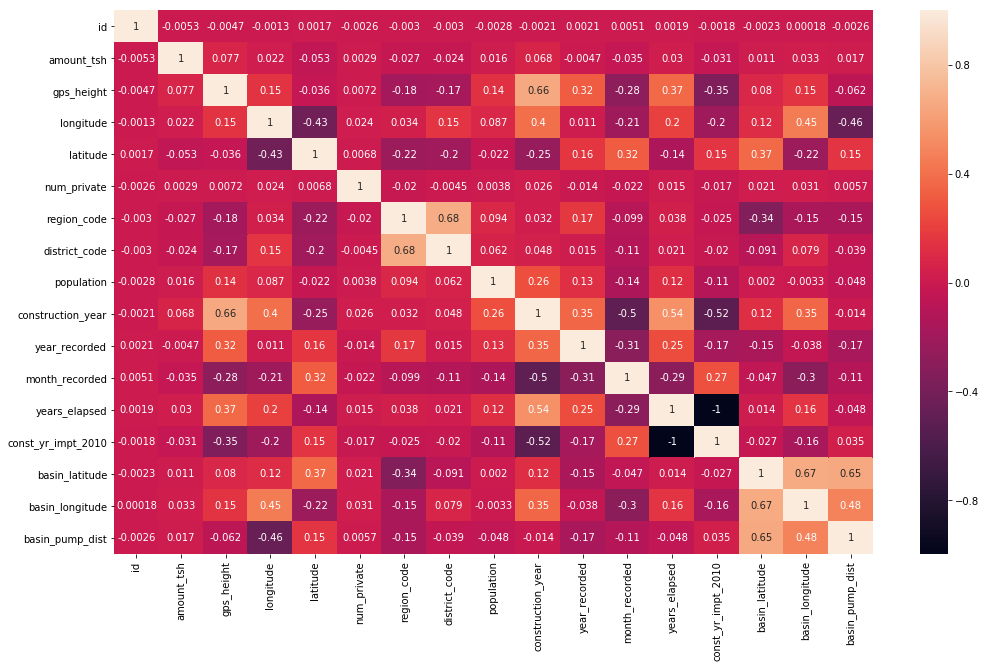

In [127]:
plt.figure(figsize=(17, 10))
sns.heatmap(train_data[num_features].corr(), annot=True)

#### The above data is very redundant , let's drop unuseful features and then redraw the graph.

In [128]:
redundant_cols = ['id','longitude', 'latitude', 'num_private','region_code','construction_year','year_recorded','month_recorded','basin_latitude','basin_longitude']

In [129]:
train_data[num_features].drop(redundant_cols, axis=1).head()

amount_tsh  gps_height  district_code  population  years_elapsed  \
0      6000.0        1390              5         109             12   
1         0.0        1399              2         280              3   
2        25.0         686              4         250              4   
3         0.0         263             63          58             27   
4         0.0           0              1           0              1   

   const_yr_impt_2010  basin_pump_dist  
0                1999       202.517704  
1                2010       396.072413  
2                2009       943.553742  
3                1986       248.454311  
4                2010       375.346864

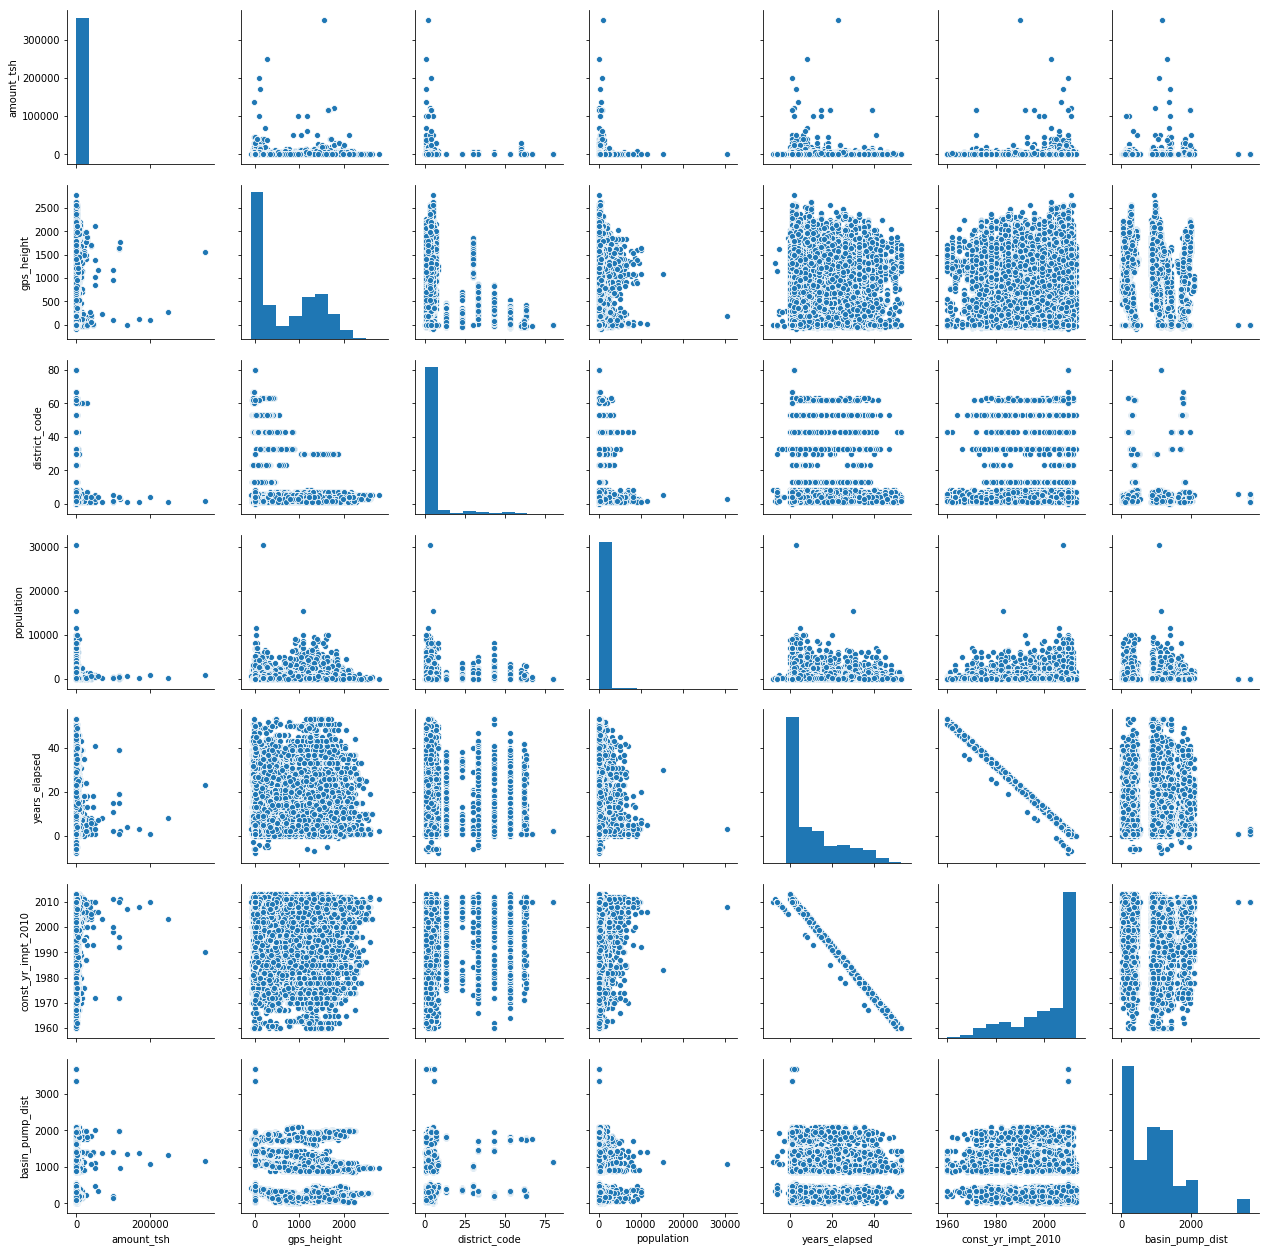

In [130]:
sns.pairplot(train_data[num_features].drop(redundant_cols, axis=1))

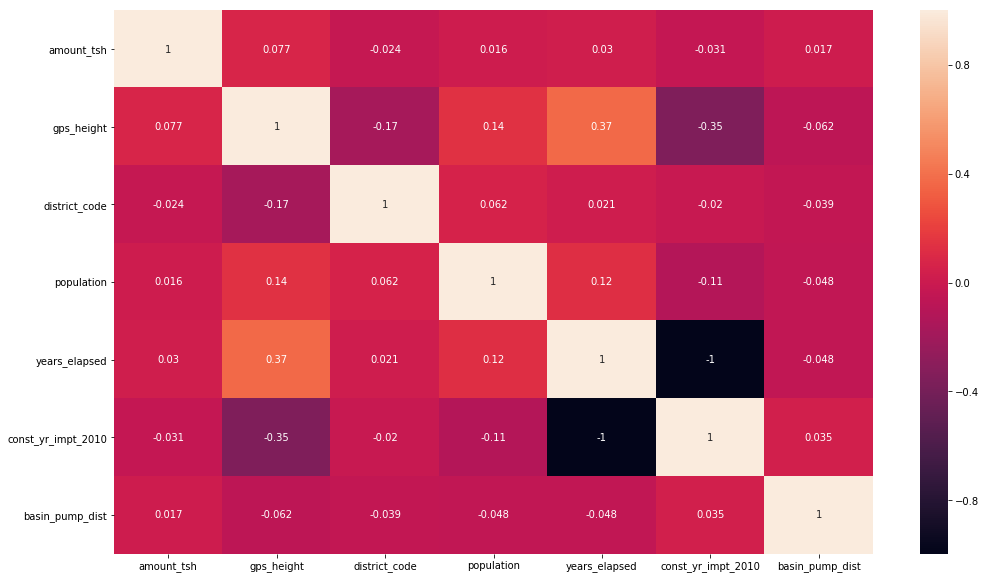

In [131]:
plt.figure(figsize=(17,10))
sns.heatmap((train_data[num_features].drop(redundant_cols, axis=1)).corr(), annot=True)

#### So all these features are important as they are not highly co-related in either direction.

##### Let's now perform some preprocessing to give the data right structure so that it can be modelled using ML algo.

In [132]:
train_data_1 = train_data.drop(redundant_cols,axis=1)

In [133]:
train_data_1.shape

(59400, 37)

In [134]:
train_data_1.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
wpt_name                     0
basin                        0
subvillage                 371
region                       0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoi

In [135]:
del(train_data)

##### imputing funder with text 'funder_missing'

In [136]:
train_data_1['funder'].fillna('funder_missing', inplace=True)

##### imputing installer with text 'installer_missing'

In [137]:
train_data_1['installer'].fillna('installer_missing', inplace=True)

##### We choose to ignore sub-village column for modelling as we are other predictors for location

In [138]:
train_data_1.drop('subvillage', axis=1, inplace=True)

##### Impute the public_meeting with text 'miss_p_mtng'

In [139]:
train_data_1['public_meeting'].fillna('miss_p_mtng', inplace=True)

##### For scheme_management(3877) and scheme_name(28166) , we can drop scheme_name as scheme_name can be identified with scheme_management , will impute scheme_management with text 'miss_sch_mngt'.

In [140]:
train_data_1['scheme_management'].fillna('miss_sch_mngt', inplace=True)

In [141]:
train_data_1.drop('scheme_name', axis=1, inplace=True)

##### For Permit we impute with text 'miss_permit', it doesn't mean 'NO' permit though.

In [142]:
train_data_1['permit'].fillna('miss_permit', inplace=True)

In [143]:
##### Now again check if there is any missing or null values
train_data_1[train_data_1.isna().any(axis=1)]

Empty DataFrame
Columns: [amount_tsh, date_recorded, funder, gps_height, installer, wpt_name, basin, region, district_code, lga, ward, population, public_meeting, recorded_by, scheme_management, permit, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group, years_elapsed, const_yr_impt_2010, basin_pump_dist]
Index: []

In [144]:
train_data_1.shape

(59400, 35)

##### dropping the date_recorded and const_yr_impt_2010 as the info from these 2 are incorporated in years_elpased

In [145]:
train_data_1.drop(['date_recorded','const_yr_impt_2010'], inplace=True, axis=1)

In [146]:
train_data_1.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name', 'basin',
       'region', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'years_elapsed', 'basin_pump_dist'],
      dtype='object')

#### From the above analysis of the variables, it has been discovered that there are many features which are redundant , which will cause below issue :
####     1. Delay in training.
####     2. High utilization of cumputing resources.
####     3. Over-fiiting/high-variance
####     4. Difficulty in interpreting the model.
#### hence it is better to drop these features.

In [147]:
redundant_cols_new = ['district_code',
'waterpoint_type_group',
'source_type',
'source_class',
'quantity_group',
'quality_group',
'payment_type',
'management_group',
'extraction_type_group',
'extraction_type_class',
'recorded_by',
'lga',
'ward',
'basin',
'wpt_name']

In [148]:
train_data_1.drop(redundant_cols_new, axis=1, inplace=True)

In [149]:
train_data_1.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'region',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'extraction_type', 'management', 'payment', 'water_quality', 'quantity',
       'source', 'waterpoint_type', 'years_elapsed', 'basin_pump_dist'],
      dtype='object')

In [150]:
train_data_1.shape

(59400, 18)

In [151]:
train_data_1.head()

amount_tsh        funder  gps_height     installer   region  population  \
0      6000.0         Roman        1390         Roman   Iringa         109   
1         0.0       Grumeti        1399       GRUMETI     Mara         280   
2        25.0  Lottery Club         686  World vision  Manyara         250   
3         0.0        Unicef         263        UNICEF   Mtwara          58   
4         0.0   Action In A           0       Artisan   Kagera           0   

  public_meeting scheme_management permit extraction_type management  \
0           True               VWC  False         gravity        vwc   
1    miss_p_mtng             Other   True         gravity        wug   
2           True               VWC   True         gravity        vwc   
3           True               VWC   True     submersible        vwc   
4           True     miss_sch_mngt   True         gravity      other   

          payment water_quality      quantity                source  \
0    pay annually          soft        enough                spring   
1       never pay          soft  insufficient  rainwater harvesting   
2  pay per bucket          soft        enough                   dam   
3       never pay          soft           dry           machine dbh   
4       never pay          soft      seasonal  rainwater harvesting   

               waterpoint_type  years_elapsed  basin_pump_dist  
0           communal standpipe             12       202.517704  
1           communal standpipe              3       396.072413  
2  communal standpipe multiple              4       943.553742  
3  communal standpipe multiple             27       248.454311  
4           communal standpipe              1       375.346864

In [152]:
# get the left over numerical columns for scaling
num_col_sc = [col for col in train_data_1.columns if train_data_1[col].dtype in('int64','float64')]

In [153]:
num_col_sc

['amount_tsh', 'gps_height', 'population', 'years_elapsed', 'basin_pump_dist']

In [154]:
train_data_1 = pd.get_dummies(train_data_1)

In [155]:
train_data_1.shape

(59400, 4156)

In [156]:
train_data_1.head()

amount_tsh  gps_height  population  years_elapsed  basin_pump_dist  \
0      6000.0        1390         109             12       202.517704   
1         0.0        1399         280              3       396.072413   
2        25.0         686         250              4       943.553742   
3         0.0         263          58             27       248.454311   
4         0.0           0           0              1       375.346864   

   funder_0  funder_A/co Germany  funder_Aar  funder_Abas Ka  funder_Abasia  \
0         0                    0           0               0              0   
1         0                    0           0               0              0   
2         0                    0           0               0              0   
3         0                    0           0               0              0   
4         0                    0           0               0              0   

   funder_Abc-ihushi Development Cent  funder_Abd  funder_Abdala  \
0                                   0           0              0   
1                                   0           0              0   
2                                   0           0              0   
3                                   0           0              0   
4                                   0           0              0   

   funder_Abddwe  funder_Abdul  funder_Abood  funder_Abs  funder_Aco/germany  \
0              0             0             0           0                   0   
1              0             0             0           0                   0   
2              0             0             0           0                   0   
3              0             0             0           0                   0   
4              0             0             0           0                   0   

   funder_Acord  funder_Acord Ngo  funder_Acra  funder_Act  funder_Act Mara  \
0             0                 0            0           0                0   
1             0                 0            0           0                0   
2             0                 0            0           0                0   
3             0                 0            0           0                0   
4             0                 0            0           0                0   

   funder_Action Aid  funder_Action Contre La Faim  funder_Action In A  \
0                  0                             0                   0   
1                  0                             0                   0   
2                  0                             0                   0   
3                  0                             0                   0   
4                  0                             0                   1   

   funder_Adap  funder_Adb  funder_Adf  funder_Adp  funder_Adp Bungu  \
0            0           0           0           0                 0   
1            0           0           0           0                 0   
2            0           0           0           0                 0   
3            0           0           0           0                 0   
4            0           0           0           0                 0   

   funder_Adp Mombo  funder_Adp/w  funder_Adra  funder_Af  funder_Afdp  \
0                 0             0            0          0            0   
1                 0             0            0          0            0   
2                 0             0            0          0            0   
3                 0             0            0          0            0   
4                 0             0            0          0            0   

   funder_Afric  funder_Africa  funder_Africa 2000 Network/undp  \
0             0              0                                0   
1             0              0                                0   
2             0              0                                0   
3             0              0                                0   
4             0              0                                0   

#### Perform the scaling of the features 


In [157]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [158]:
train_data_1[num_col_sc] = sc.fit_transform(train_data_1[num_col_sc])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [159]:
train_data_1.head()

amount_tsh  gps_height  population  years_elapsed  basin_pump_dist  \
0    1.895665    1.041252   -0.150399       0.123433        -0.963565   
1   -0.105970    1.054237    0.212290      -0.622187        -0.705447   
2   -0.097630    0.025541    0.148660      -0.539340         0.024655   
3   -0.105970   -0.584751   -0.258570       1.366133        -0.902306   
4   -0.105970   -0.964200   -0.381587      -0.787880        -0.733086   

   funder_0  funder_A/co Germany  funder_Aar  funder_Abas Ka  funder_Abasia  \
0         0                    0           0               0              0   
1         0                    0           0               0              0   
2         0                    0           0               0              0   
3         0                    0           0               0              0   
4         0                    0           0               0              0   

   funder_Abc-ihushi Development Cent  funder_Abd  funder_Abdala  \
0                                   0           0              0   
1                                   0           0              0   
2                                   0           0              0   
3                                   0           0              0   
4                                   0           0              0   

   funder_Abddwe  funder_Abdul  funder_Abood  funder_Abs  funder_Aco/germany  \
0              0             0             0           0                   0   
1              0             0             0           0                   0   
2              0             0             0           0                   0   
3              0             0             0           0                   0   
4              0             0             0           0                   0   

   funder_Acord  funder_Acord Ngo  funder_Acra  funder_Act  funder_Act Mara  \
0             0                 0            0           0                0   
1             0                 0            0           0                0   
2             0                 0            0           0                0   
3             0                 0            0           0                0   
4             0                 0            0           0                0   

   funder_Action Aid  funder_Action Contre La Faim  funder_Action In A  \
0                  0                             0                   0   
1                  0                             0                   0   
2                  0                             0                   0   
3                  0                             0                   0   
4                  0                             0                   1   

   funder_Adap  funder_Adb  funder_Adf  funder_Adp  funder_Adp Bungu  \
0            0           0           0           0                 0   
1            0           0           0           0                 0   
2            0           0           0           0                 0   
3            0           0           0           0                 0   
4            0           0           0           0                 0   

   funder_Adp Mombo  funder_Adp/w  funder_Adra  funder_Af  funder_Afdp  \
0                 0             0            0          0            0   
1                 0             0            0          0            0   
2                 0             0            0          0            0   
3                 0             0            0          0            0   
4                 0             0            0          0            0   

   funder_Afric  funder_Africa  funder_Africa 2000 Network/undp  \
0             0              0                                0   
1             0              0                                0   
2             0              0                                0   
3             0              0                                0   
4             0              0                                0   

In [160]:
col_lst = train_data_1.columns

In [161]:
col_lst

Index(['amount_tsh', 'gps_height', 'population', 'years_elapsed',
       'basin_pump_dist', 'funder_0', 'funder_A/co Germany', 'funder_Aar',
       'funder_Abas Ka', 'funder_Abasia',
       ...
       'source_shallow well', 'source_spring', 'source_unknown',
       'waterpoint_type_cattle trough', 'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam',
       'waterpoint_type_hand pump', 'waterpoint_type_improved spring',
       'waterpoint_type_other'],
      dtype='object', length=4156)

In [162]:
# dropping one column each from the group of newly created dummy columns to ward off the issue of multi-collinearity
train_data_1.drop(['funder_funder_missing','installer_installer_missing','region_Iringa',
                   'public_meeting_miss_p_mtng','scheme_management_miss_sch_mngt','permit_miss_permit',
                  'management_other - school','payment_unknown','water_quality_unknown',
                  'quantity_unknown','source_unknown','water_quality_unknown'], axis=1, inplace=True)

In [163]:
train_data_1.shape

(59400, 4145)

##### Import the training target data-set

In [365]:
# import the train-target dataset
train_target = pd.read_csv('raw_train_target_vectors.csv')

In [366]:
train_target.shape

(59400, 2)

In [367]:
train_target.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

In [368]:
train_target['status_group'].isna().sum()

0

In [369]:
train_target['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

##### pre-processing the target variable from being categorical to numerical

In [370]:
train_target['status_group'] = train_target['status_group'].map({'functional':0,
                                                                 'non functional':1,
                                                                 'functional needs repair':2})

In [318]:
train_target.head()

0    0
1    0
2    0
3    1
4    0
Name: status_group, dtype: int64

In [171]:
train_target = train_target['status_group']

###### Now let's segregate the entire data set into train , validation and test sets

In [319]:
from sklearn.model_selection import train_test_split

In [327]:
X_train, X_test, y_train, y_test = train_test_split(train_data_1,train_target,test_size=.15,
                                                    random_state=321)

In [328]:
## get validation set from train set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, 
                                                      random_state=313)

In [329]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((40392, 4145), (10098, 4145), (8910, 4145), (40392,), (10098,), (8910,))

###### At this moment I am compelled to perform dimensionality reduction step - namely PCA to compress my feature space of several thousand features.

In [330]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(X_train)

#pca_samples = pca.transform(train_data_1)


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [331]:
pca.n_components_

136

In [313]:
pca.explained_variance_ratio_

array([0.12822833, 0.0892335 , 0.08197641, 0.07738054, 0.05933666,
       0.04592652, 0.03761974, 0.03254067, 0.0292746 , 0.02666826,
       0.02030454, 0.0169611 , 0.01622157, 0.01521431, 0.01304298,
       0.01219111, 0.011536  , 0.01099073, 0.0098409 , 0.00953179,
       0.00884177, 0.00763352, 0.00735443, 0.00729742, 0.00657773,
       0.00595982, 0.0057316 , 0.00516616, 0.00498214, 0.00491715,
       0.00451783, 0.00436116, 0.00418003, 0.00390396, 0.00381815,
       0.00374392, 0.00365451, 0.00358327, 0.00350678, 0.00329978,
       0.00309766, 0.00299255, 0.0029528 , 0.00282128, 0.00278156,
       0.00265938, 0.00261969, 0.00258057, 0.00243823, 0.0023699 ,
       0.00224707, 0.00218801, 0.00215508, 0.00204343, 0.0020147 ,
       0.00194403, 0.00188566, 0.0018381 , 0.00178667, 0.0016899 ,
       0.00163151, 0.00160954, 0.00158515, 0.00154052, 0.00146876,
       0.00143221, 0.00141691, 0.00138489, 0.00134239, 0.00131341,
       0.00129063, 0.00126102, 0.00116261, 0.00112661, 0.00111

In [332]:
for n_compnt in [50,60,70,75,80,85,90,95,100,110,120,125,130,135]:
    print('{} % of variance is explained by first {} components.'
      .format((round(np.cumsum(pca.explained_variance_ratio_)[n_compnt],2) * 100),n_compnt))

88.0 % of variance is explained by first 50 components.
90.0 % of variance is explained by first 60 components.
91.0 % of variance is explained by first 70 components.
92.0 % of variance is explained by first 75 components.
92.0 % of variance is explained by first 80 components.
93.0 % of variance is explained by first 85 components.
93.0 % of variance is explained by first 90 components.
93.0 % of variance is explained by first 95 components.
94.0 % of variance is explained by first 100 components.
94.0 % of variance is explained by first 110 components.
94.0 % of variance is explained by first 120 components.
95.0 % of variance is explained by first 125 components.
95.0 % of variance is explained by first 130 components.
95.0 % of variance is explained by first 135 components.


##### Apply the mapping/transformation to train, validation and test sets.

In [333]:
X_train = pca.transform(X_train)
X_valid = pca.transform(X_valid)
X_test = pca.transform(X_test)

In [334]:
X_train.shape , X_valid.shape, X_test.shape

((40392, 136), (10098, 136), (8910, 136))

In [335]:
X_train[:5,:5]

array([[ 0.09558042,  0.20629677,  1.10368332, -1.43542895, -1.27141352],
       [-1.56349914, -0.07807022,  0.06527295,  0.92176458, -0.39106082],
       [ 0.8930848 , -0.27636336,  0.90167219, -0.51384158,  0.07970041],
       [ 0.9443107 , -0.06926744, -0.70016221, -0.05104971,  1.31398127],
       [-0.72705389, -0.12687915, -0.72443054,  1.20887384,  0.58719472]])

#### Model Selection steps

In [203]:
from sklearn.metrics import accuracy_score
from time import time

In [222]:
def probable_models(classifier, train_ftr_set, valid_ftr_set, train_trgt_set, valid_trgt_set):
    '''
    defining a function to iterative run over a list of classifiers and generate a 
    comparison matrix
    '''
    
    result = {}
    
    start_tm = time()
    classifier = classifier.fit(train_ftr_set, train_trgt_set)
    end_tm = time()
    
    result['train_score'] = classifier.score(train_ftr_set, train_trgt_set)
    result['valid_score'] = classifier.score(valid_ftr_set, valid_trgt_set)
    result['time'] = end_tm - start_tm
    
    start_tm = 0
    end_tm = 0
    
    return result    

In [223]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [224]:
clf_a = SVC(random_state = 313)
clf_b = GaussianNB()
clf_c = KNeighborsClassifier()
clf_d = DecisionTreeClassifier(random_state = 313)
clf_e = RandomForestClassifier(criterion='entropy', random_state = 313)
clf_f = AdaBoostClassifier(random_state = 313)
clf_g = GradientBoostingClassifier(random_state = 313)
clf_h = ExtraTreesClassifier(criterion='entropy', random_state=313)
clf_i = MLPClassifier(random_state = 313)

results = {}

for clf in [clf_a, clf_b, clf_c, clf_d, clf_e, clf_f, clf_g, clf_h, clf_i]:
    name = clf.__class__.__name__
    results[name] = probable_models(clf, X_train, X_valid, y_train, y_valid)
    

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWar

In [219]:
results

{'SVC': {'train_score': 0.7376213111507229,
  'valid_score': 0.7370766488413547,
  'accuracy': 0.7370766488413547,
  'time': 228.85598397254944},
 'GaussianNB': {'train_score': 0.4734353337294514,
  'valid_score': 0.4726678550207962,
  'accuracy': 0.4726678550207962,
  'time': 0.10456705093383789},
 'KNeighborsClassifier': {'train_score': 0.8353881956823134,
  'valid_score': 0.7756981580510992,
  'accuracy': 0.7756981580510992,
  'time': 0.23358511924743652},
 'DecisionTreeClassifier': {'train_score': 0.9974499900970489,
  'valid_score': 0.7265795206971678,
  'accuracy': 0.7265795206971678,
  'time': 11.238741874694824},
 'RandomForestClassifier': {'train_score': 0.9784363240245593,
  'valid_score': 0.7687660922955041,
  'accuracy': 0.7687660922955041,
  'time': 6.3978822231292725},
 'AdaBoostClassifier': {'train_score': 0.7049168152109329,
  'valid_score': 0.7021192315309962,
  'accuracy': 0.7021192315309962,
  'time': 31.82717800140381},
 'GradientBoostingClassifier': {'train_score':

In [234]:
model_selection_df = pd.DataFrame(results).T

In [236]:
model_selection_df

time  train_score  valid_score
SVC                         229.135942     0.737621     0.737077
GaussianNB                    0.090633     0.473435     0.472668
KNeighborsClassifier          0.224467     0.835388     0.775698
DecisionTreeClassifier       11.433602     0.997450     0.726580
RandomForestClassifier        6.389280     0.978436     0.768766
AdaBoostClassifier           31.773513     0.704917     0.702119
GradientBoostingClassifier  167.763767     0.770499     0.762527
ExtraTreesClassifier          1.344342     0.997450     0.762428
MLPClassifier                64.558635     0.865790     0.773718

In [227]:
t1 = time()

In [228]:
t2 = time()

In [229]:
t2 - t1

7.368470191955566

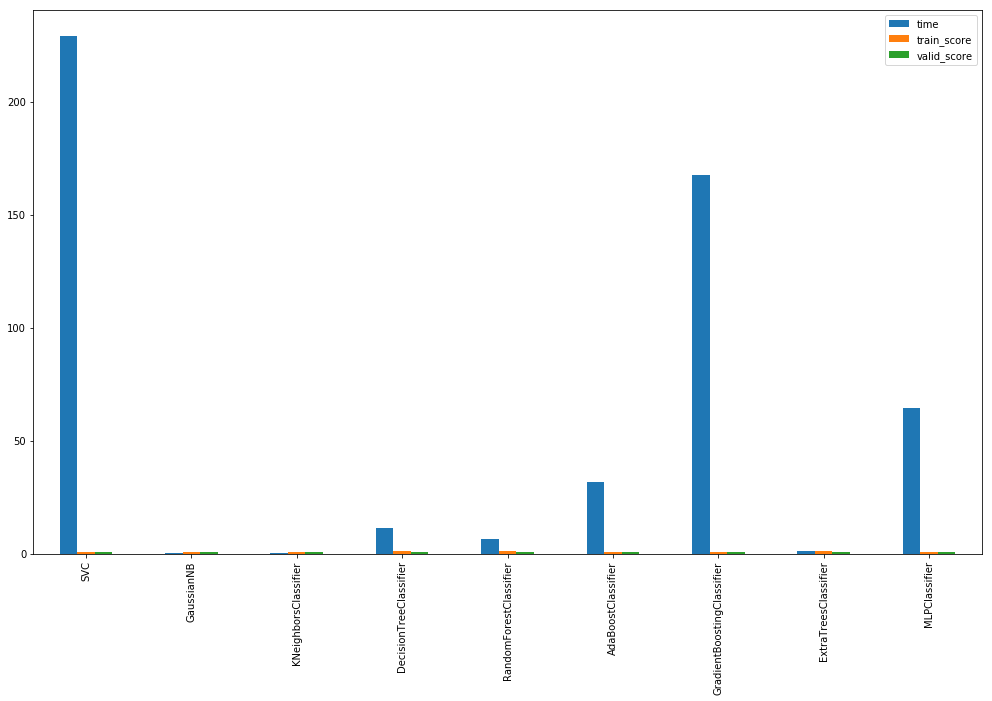

In [232]:
model_selection_df.T.plot(kind = 'bar', figsize=(17,10))

##### Difficult to visualize the comparative graph, so let's normalize the data and see.

In [240]:
model_selection_df['time'] = (model_selection_df['time'] - min(model_selection_df['time']))/(max(model_selection_df['time']) - min(model_selection_df['time']))
model_selection_df['train_score'] = (model_selection_df['train_score'] - min(model_selection_df['train_score']))/(max(model_selection_df['train_score']) - min(model_selection_df['train_score']))
model_selection_df['valid_score'] = (model_selection_df['valid_score'] - min(model_selection_df['valid_score']))/(max(model_selection_df['valid_score']) - min(model_selection_df['valid_score']))

In [243]:
model_selection_df

time  train_score  valid_score
SVC                         1.000000     0.504158     0.872549
GaussianNB                  0.000000     0.000000     0.000000
KNeighborsClassifier        0.000584     0.690730     1.000000
DecisionTreeClassifier      0.049523     1.000000     0.837908
RandomForestClassifier      0.027500     0.963715     0.977124
AdaBoostClassifier          0.138326     0.441746     0.757190
GradientBoostingClassifier  0.732052     0.566900     0.956536
ExtraTreesClassifier        0.005474     1.000000     0.956209
MLPClassifier               0.281464     0.748748     0.993464

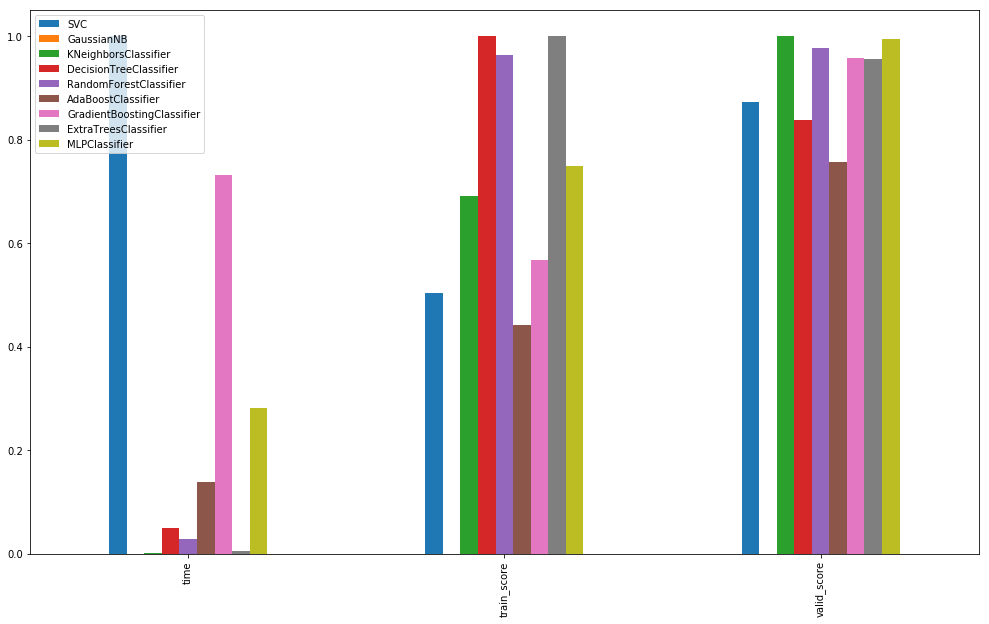

In [242]:
model_selection_df.T.plot(kind='bar', figsize=(17,10))

##### Hence, from above it's clear that we will try out with KNN and MLP for further parameter tuning and attain better results.

##### Let's now perform the grid-serach with cross-validation to find the best hyper-parameters for KNN.

In [245]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [264]:
# let's define the parameters dictionary for KNN
'''
parameters = {'n_neighbors' :list(range(20,150,10)),
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : list(range(20,150,10)),
              'p':[1,2, 3, 4]
             }
'''
parameters = {'n_neighbors' :[5],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : [30],
              'p':[2]
             }

start_tm = time()

scorer = make_scorer(accuracy_score)
clf = KNeighborsClassifier()
grid_obj = GridSearchCV(clf,
                        param_grid=parameters,
                        scoring=scorer,
                        ##cv=10,
                        n_jobs=-1)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
base_pred = (clf.fit(X_train, y_train)).predict(X_valid)
best_pred = best_clf.predict(X_valid)

end_tm = time()

print('The prediction by base KNN validation set is : {}'.format(accuracy_score(y_valid, base_pred)),
      '\nThe prediction by optimized KNN on validation set is : {}'.format(accuracy_score(y_valid, best_pred)),
      '\nTime taken is : {:.4f} sec'.format(end_tm - start_tm))




/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The prediction by base KNN validation set is : 0.7756981580510992 
The prediction by optimized KNN on validation set is : 0.7753020400079224 
Time taken is : 409.0240 sec


###### Capturing the run of individual combinations as complete grid was taking too much of time.  Due to time constarint , as I have to submit the analysis for Axiata Analytics.

In [265]:
best_clf.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')>

In [ ]:
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

The prediction by base KNN validation set is : 0.7756981580510992 
The prediction by optimized KNN on validation set is : 0.7712418300653595 
Time taken is : 171.2059 sec

In [ ]:
KNeighborsClassifier(algorithm='auto', leaf_size=40, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')
                     
The prediction by base KNN validation set is : 0.7756981580510992 
The prediction by optimized KNN on validation set is : 0.7713408595761537 
Time taken is : 151.4696 sec

In [ ]:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

The prediction by base KNN validation set is : 0.7756981580510992 
The prediction by optimized KNN on validation set is : 0.767379679144385 
Time taken is : 181.1374 sec

In [ ]:
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

The prediction by base KNN validation set is : 0.7756981580510992 
The prediction by optimized KNN on validation set is : 0.7756981580510992 
Time taken is : 109.9834 sec

In [ ]:
'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

The prediction by base KNN validation set is : 0.7756981580510992 
The prediction by optimized KNN on validation set is : 0.7753020400079224 
Time taken is : 409.0240 sec

##### Now trying out with Neural Networks using keras with tensorflow backend

In [339]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import Adam,SGD,RMSprop
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from keras.utils import np_utils


In [340]:
X_train.shape

(40392, 136)

In [341]:
nb_classes = 3
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)


In [343]:
y_train.shape, y_valid.shape, y_test.shape

((40392, 3), (10098, 3), (8910, 3))

In [344]:
# first model architechture
np.random.seed(13)

model = Sequential()
model.add(Dense(1024, kernel_regularizer=regularizers.l2(.001),input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512,kernel_regularizer=regularizers.l2(.001)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(128,kernel_regularizer=regularizers.l1_l2(.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(32, kernel_regularizer=regularizers.l2(.001)))
model.add(Activation('relu'))
model.add(Dense(3, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1024)              140288    
_________________________________________________________________
activation_33 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_34 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               65664     
__________

In [345]:
# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [346]:
from keras.callbacks import ModelCheckpoint  

# checkpoint
filepath="weights-improvement-best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list_1 = [checkpoint]

# training the model

start_time = time()
model.fit(X_train,y_train,batch_size= 10000, epochs= 500,
          validation_data=(X_valid,y_valid),
          #validation_split = 0.2,
         verbose =2,callbacks = callbacks_list_1)
end_time = time()

Train on 40392 samples, validate on 10098 samples
Epoch 1/500
 - 3s - loss: 6.6574 - acc: 0.4958 - val_loss: 5.6679 - val_acc: 0.6596

Epoch 00001: val_loss improved from inf to 5.66787, saving model to weights-improvement-best-model.hdf5
Epoch 2/500
 - 3s - loss: 5.4453 - acc: 0.6364 - val_loss: 4.8705 - val_acc: 0.7239

Epoch 00002: val_loss improved from 5.66787 to 4.87046, saving model to weights-improvement-best-model.hdf5
Epoch 3/500
 - 3s - loss: 4.6836 - acc: 0.7190 - val_loss: 4.3321 - val_acc: 0.6666

Epoch 00003: val_loss improved from 4.87046 to 4.33205, saving model to weights-improvement-best-model.hdf5
Epoch 4/500
 - 3s - loss: 4.1889 - acc: 0.7001 - val_loss: 3.7808 - val_acc: 0.7408

Epoch 00004: val_loss improved from 4.33205 to 3.78081, saving model to weights-improvement-best-model.hdf5
Epoch 5/500
 - 3s - loss: 3.6601 - acc: 0.7374 - val_loss: 3.3519 - val_acc: 0.7490

Epoch 00005: val_loss improved from 3.78081 to 3.35190, saving model to weights-improvement-best-

 - 3s - loss: 0.7100 - acc: 0.7670 - val_loss: 0.7059 - val_acc: 0.7673

Epoch 00048: val_loss improved from 0.71222 to 0.70593, saving model to weights-improvement-best-model.hdf5
Epoch 49/500
 - 3s - loss: 0.7074 - acc: 0.7677 - val_loss: 0.7077 - val_acc: 0.7667

Epoch 00049: val_loss did not improve from 0.70593
Epoch 50/500
 - 3s - loss: 0.7340 - acc: 0.7513 - val_loss: 0.7132 - val_acc: 0.7638

Epoch 00050: val_loss did not improve from 0.70593
Epoch 51/500
 - 3s - loss: 0.7072 - acc: 0.7645 - val_loss: 0.7063 - val_acc: 0.7684

Epoch 00051: val_loss did not improve from 0.70593
Epoch 52/500
 - 3s - loss: 0.7034 - acc: 0.7674 - val_loss: 0.7070 - val_acc: 0.7678

Epoch 00052: val_loss did not improve from 0.70593
Epoch 53/500
 - 3s - loss: 0.7190 - acc: 0.7561 - val_loss: 0.7100 - val_acc: 0.7617

Epoch 00053: val_loss did not improve from 0.70593
Epoch 54/500
 - 3s - loss: 0.7038 - acc: 0.7668 - val_loss: 0.7050 - val_acc: 0.7644

Epoch 00054: val_loss improved from 0.70593 to 0


Epoch 00102: val_loss improved from 0.68103 to 0.68016, saving model to weights-improvement-best-model.hdf5
Epoch 103/500
 - 3s - loss: 0.6629 - acc: 0.7861 - val_loss: 0.6899 - val_acc: 0.7721

Epoch 00103: val_loss did not improve from 0.68016
Epoch 104/500
 - 3s - loss: 0.6773 - acc: 0.7778 - val_loss: 0.6950 - val_acc: 0.7672

Epoch 00104: val_loss did not improve from 0.68016
Epoch 105/500
 - 3s - loss: 0.6660 - acc: 0.7839 - val_loss: 0.6814 - val_acc: 0.7789

Epoch 00105: val_loss did not improve from 0.68016
Epoch 106/500
 - 3s - loss: 0.6630 - acc: 0.7865 - val_loss: 0.6790 - val_acc: 0.7784

Epoch 00106: val_loss improved from 0.68016 to 0.67900, saving model to weights-improvement-best-model.hdf5
Epoch 107/500
 - 3s - loss: 0.6786 - acc: 0.7768 - val_loss: 0.7279 - val_acc: 0.7592

Epoch 00107: val_loss did not improve from 0.67900
Epoch 108/500
 - 3s - loss: 0.6789 - acc: 0.7795 - val_loss: 0.6912 - val_acc: 0.7709

Epoch 00108: val_loss did not improve from 0.67900
Epoch 


Epoch 00159: val_loss did not improve from 0.67688
Epoch 160/500
 - 3s - loss: 0.6462 - acc: 0.7977 - val_loss: 0.6825 - val_acc: 0.7723

Epoch 00160: val_loss did not improve from 0.67688
Epoch 161/500
 - 3s - loss: 0.6649 - acc: 0.7843 - val_loss: 0.6854 - val_acc: 0.7728

Epoch 00161: val_loss did not improve from 0.67688
Epoch 162/500
 - 3s - loss: 0.6450 - acc: 0.7991 - val_loss: 0.6782 - val_acc: 0.7799

Epoch 00162: val_loss did not improve from 0.67688
Epoch 163/500
 - 3s - loss: 0.6427 - acc: 0.7987 - val_loss: 0.6958 - val_acc: 0.7723

Epoch 00163: val_loss did not improve from 0.67688
Epoch 164/500
 - 3s - loss: 0.6795 - acc: 0.7772 - val_loss: 0.6712 - val_acc: 0.7795

Epoch 00164: val_loss improved from 0.67688 to 0.67119, saving model to weights-improvement-best-model.hdf5
Epoch 165/500
 - 3s - loss: 0.6432 - acc: 0.7982 - val_loss: 0.6875 - val_acc: 0.7766

Epoch 00165: val_loss did not improve from 0.67119
Epoch 166/500
 - 3s - loss: 0.6545 - acc: 0.7907 - val_loss: 0.


Epoch 00218: val_loss did not improve from 0.66956
Epoch 219/500
 - 3s - loss: 0.6398 - acc: 0.7994 - val_loss: 0.6802 - val_acc: 0.7830

Epoch 00219: val_loss did not improve from 0.66956
Epoch 220/500
 - 3s - loss: 0.6373 - acc: 0.8005 - val_loss: 0.7087 - val_acc: 0.7517

Epoch 00220: val_loss did not improve from 0.66956
Epoch 221/500
 - 3s - loss: 0.6527 - acc: 0.7910 - val_loss: 0.6850 - val_acc: 0.7782

Epoch 00221: val_loss did not improve from 0.66956
Epoch 222/500
 - 3s - loss: 0.6330 - acc: 0.8040 - val_loss: 0.6838 - val_acc: 0.7778

Epoch 00222: val_loss did not improve from 0.66956
Epoch 223/500
 - 3s - loss: 0.6431 - acc: 0.7980 - val_loss: 0.6815 - val_acc: 0.7749

Epoch 00223: val_loss did not improve from 0.66956
Epoch 224/500
 - 3s - loss: 0.6356 - acc: 0.8027 - val_loss: 0.6942 - val_acc: 0.7746

Epoch 00224: val_loss did not improve from 0.66956
Epoch 225/500
 - 3s - loss: 0.6486 - acc: 0.7935 - val_loss: 0.6912 - val_acc: 0.7612

Epoch 00225: val_loss did not imp

 - 3s - loss: 0.6207 - acc: 0.8099 - val_loss: 0.7231 - val_acc: 0.7496

Epoch 00278: val_loss did not improve from 0.66956
Epoch 279/500
 - 3s - loss: 0.6488 - acc: 0.7931 - val_loss: 0.6830 - val_acc: 0.7787

Epoch 00279: val_loss did not improve from 0.66956
Epoch 280/500
 - 3s - loss: 0.6200 - acc: 0.8104 - val_loss: 0.6757 - val_acc: 0.7800

Epoch 00280: val_loss did not improve from 0.66956
Epoch 281/500
 - 3s - loss: 0.6222 - acc: 0.8085 - val_loss: 0.6863 - val_acc: 0.7802

Epoch 00281: val_loss did not improve from 0.66956
Epoch 282/500
 - 3s - loss: 0.6317 - acc: 0.8035 - val_loss: 0.6997 - val_acc: 0.7647

Epoch 00282: val_loss did not improve from 0.66956
Epoch 283/500
 - 3s - loss: 0.6402 - acc: 0.7973 - val_loss: 0.6855 - val_acc: 0.7780

Epoch 00283: val_loss did not improve from 0.66956
Epoch 284/500
 - 3s - loss: 0.6289 - acc: 0.8035 - val_loss: 0.6759 - val_acc: 0.7794

Epoch 00284: val_loss did not improve from 0.66956
Epoch 285/500
 - 3s - loss: 0.6162 - acc: 0.8112


Epoch 00337: val_loss did not improve from 0.66956
Epoch 338/500
 - 3s - loss: 0.6335 - acc: 0.8016 - val_loss: 0.6754 - val_acc: 0.7840

Epoch 00338: val_loss did not improve from 0.66956
Epoch 339/500
 - 3s - loss: 0.6112 - acc: 0.8151 - val_loss: 0.7180 - val_acc: 0.7721

Epoch 00339: val_loss did not improve from 0.66956
Epoch 340/500
 - 3s - loss: 0.6313 - acc: 0.8028 - val_loss: 0.6779 - val_acc: 0.7786

Epoch 00340: val_loss did not improve from 0.66956
Epoch 341/500
 - 3s - loss: 0.6113 - acc: 0.8116 - val_loss: 0.6905 - val_acc: 0.7799

Epoch 00341: val_loss did not improve from 0.66956
Epoch 342/500
 - 3s - loss: 0.6190 - acc: 0.8088 - val_loss: 0.7001 - val_acc: 0.7614

Epoch 00342: val_loss did not improve from 0.66956
Epoch 343/500
 - 3s - loss: 0.6224 - acc: 0.8069 - val_loss: 0.6720 - val_acc: 0.7876

Epoch 00343: val_loss did not improve from 0.66956
Epoch 344/500
 - 3s - loss: 0.6091 - acc: 0.8159 - val_loss: 0.6828 - val_acc: 0.7814

Epoch 00344: val_loss did not imp

 - 3s - loss: 0.6033 - acc: 0.8174 - val_loss: 0.6927 - val_acc: 0.7654

Epoch 00397: val_loss did not improve from 0.66956
Epoch 398/500
 - 3s - loss: 0.6430 - acc: 0.7956 - val_loss: 0.6853 - val_acc: 0.7859

Epoch 00398: val_loss did not improve from 0.66956
Epoch 399/500
 - 3s - loss: 0.6064 - acc: 0.8174 - val_loss: 0.6876 - val_acc: 0.7723

Epoch 00399: val_loss did not improve from 0.66956
Epoch 400/500
 - 3s - loss: 0.6186 - acc: 0.8060 - val_loss: 0.6945 - val_acc: 0.7809

Epoch 00400: val_loss did not improve from 0.66956
Epoch 401/500
 - 3s - loss: 0.6148 - acc: 0.8127 - val_loss: 0.6870 - val_acc: 0.7762

Epoch 00401: val_loss did not improve from 0.66956
Epoch 402/500
 - 3s - loss: 0.6156 - acc: 0.8098 - val_loss: 0.7292 - val_acc: 0.7708

Epoch 00402: val_loss did not improve from 0.66956
Epoch 403/500
 - 3s - loss: 0.6235 - acc: 0.8077 - val_loss: 0.6800 - val_acc: 0.7790

Epoch 00403: val_loss did not improve from 0.66956
Epoch 404/500
 - 3s - loss: 0.6034 - acc: 0.8200

 - 4s - loss: 0.6165 - acc: 0.8103 - val_loss: 0.6899 - val_acc: 0.7694

Epoch 00456: val_loss did not improve from 0.66761
Epoch 457/500
 - 4s - loss: 0.6024 - acc: 0.8182 - val_loss: 0.6872 - val_acc: 0.7815

Epoch 00457: val_loss did not improve from 0.66761
Epoch 458/500
 - 4s - loss: 0.6082 - acc: 0.8163 - val_loss: 0.7075 - val_acc: 0.7644

Epoch 00458: val_loss did not improve from 0.66761
Epoch 459/500
 - 3s - loss: 0.6153 - acc: 0.8091 - val_loss: 0.6998 - val_acc: 0.7818

Epoch 00459: val_loss did not improve from 0.66761
Epoch 460/500
 - 3s - loss: 0.6000 - acc: 0.8214 - val_loss: 0.6965 - val_acc: 0.7636

Epoch 00460: val_loss did not improve from 0.66761
Epoch 461/500
 - 3s - loss: 0.6201 - acc: 0.8071 - val_loss: 0.7067 - val_acc: 0.7867

Epoch 00461: val_loss did not improve from 0.66761
Epoch 462/500
 - 3s - loss: 0.6019 - acc: 0.8185 - val_loss: 0.7207 - val_acc: 0.7739

Epoch 00462: val_loss did not improve from 0.66761
Epoch 463/500
 - 3s - loss: 0.6146 - acc: 0.8113

In [347]:
# trying another architechture : model_1
model_1 = Sequential()
model_1.add(Dense(1024, kernel_regularizer=regularizers.l2(.001),input_dim=X_train.shape[1]))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(512,kernel_regularizer=regularizers.l2(.001)))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(512,kernel_regularizer=regularizers.l2(.001)))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(128,kernel_regularizer=regularizers.l1_l2(.001)))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(32, kernel_regularizer=regularizers.l2(.001)))
model_1.add(Activation('relu'))
model_1.add(Dense(3, activation = 'softmax'))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 1024)              140288    
_________________________________________________________________
activation_37 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_38 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
__________

In [349]:
# compile the model_1
model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [350]:
# checkpoint
filepath="weights-improvement-best-model_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list_1 = [checkpoint]

# training the model

start_time = time()
model_1.fit(X_train,y_train,batch_size= 1000, epochs= 250,
          validation_data=(X_valid,y_valid),
          #validation_split = 0.2,
         verbose =2,callbacks = callbacks_list_1)
end_time = time()

Train on 40392 samples, validate on 10098 samples
Epoch 1/250
 - 4s - loss: 4.4220 - acc: 0.6810 - val_loss: 2.4390 - val_acc: 0.7485

Epoch 00001: val_loss improved from inf to 2.43905, saving model to weights-improvement-best-model_1.hdf5
Epoch 2/250
 - 4s - loss: 1.6267 - acc: 0.7389 - val_loss: 1.0277 - val_acc: 0.7550

Epoch 00002: val_loss improved from 2.43905 to 1.02766, saving model to weights-improvement-best-model_1.hdf5
Epoch 3/250
 - 4s - loss: 0.9020 - acc: 0.7473 - val_loss: 0.8926 - val_acc: 0.7160

Epoch 00003: val_loss improved from 1.02766 to 0.89259, saving model to weights-improvement-best-model_1.hdf5
Epoch 4/250
 - 4s - loss: 0.8043 - acc: 0.7495 - val_loss: 0.7903 - val_acc: 0.7440

Epoch 00004: val_loss improved from 0.89259 to 0.79030, saving model to weights-improvement-best-model_1.hdf5
Epoch 5/250
 - 4s - loss: 0.7647 - acc: 0.7537 - val_loss: 0.8050 - val_acc: 0.7349

Epoch 00005: val_loss did not improve from 0.79030
Epoch 6/250
 - 4s - loss: 0.7497 - acc

 - 4s - loss: 0.6245 - acc: 0.8024 - val_loss: 0.6703 - val_acc: 0.7859

Epoch 00054: val_loss did not improve from 0.65928
Epoch 55/250
 - 4s - loss: 0.6253 - acc: 0.8024 - val_loss: 0.6692 - val_acc: 0.7774

Epoch 00055: val_loss did not improve from 0.65928
Epoch 56/250
 - 4s - loss: 0.6245 - acc: 0.8032 - val_loss: 0.7009 - val_acc: 0.7569

Epoch 00056: val_loss did not improve from 0.65928
Epoch 57/250
 - 4s - loss: 0.6235 - acc: 0.8030 - val_loss: 0.6594 - val_acc: 0.7863

Epoch 00057: val_loss did not improve from 0.65928
Epoch 58/250
 - 4s - loss: 0.6213 - acc: 0.8037 - val_loss: 0.6613 - val_acc: 0.7837

Epoch 00058: val_loss did not improve from 0.65928
Epoch 59/250
 - 4s - loss: 0.6247 - acc: 0.8025 - val_loss: 0.6723 - val_acc: 0.7878

Epoch 00059: val_loss did not improve from 0.65928
Epoch 60/250
 - 4s - loss: 0.6228 - acc: 0.8022 - val_loss: 0.6675 - val_acc: 0.7903

Epoch 00060: val_loss did not improve from 0.65928
Epoch 61/250
 - 4s - loss: 0.6205 - acc: 0.8036 - val_


Epoch 00113: val_loss did not improve from 0.65702
Epoch 114/250
 - 4s - loss: 0.5950 - acc: 0.8195 - val_loss: 0.6765 - val_acc: 0.7745

Epoch 00114: val_loss did not improve from 0.65702
Epoch 115/250
 - 4s - loss: 0.5932 - acc: 0.8196 - val_loss: 0.6653 - val_acc: 0.7895

Epoch 00115: val_loss did not improve from 0.65702
Epoch 116/250
 - 4s - loss: 0.5900 - acc: 0.8203 - val_loss: 0.6707 - val_acc: 0.7858

Epoch 00116: val_loss did not improve from 0.65702
Epoch 117/250
 - 4s - loss: 0.5950 - acc: 0.8187 - val_loss: 0.6738 - val_acc: 0.7860

Epoch 00117: val_loss did not improve from 0.65702
Epoch 118/250
 - 4s - loss: 0.5953 - acc: 0.8177 - val_loss: 0.6944 - val_acc: 0.7890

Epoch 00118: val_loss did not improve from 0.65702
Epoch 119/250
 - 4s - loss: 0.5938 - acc: 0.8175 - val_loss: 0.6872 - val_acc: 0.7896

Epoch 00119: val_loss did not improve from 0.65702
Epoch 120/250
 - 4s - loss: 0.5913 - acc: 0.8189 - val_loss: 0.7274 - val_acc: 0.7811

Epoch 00120: val_loss did not imp

 - 4s - loss: 0.5787 - acc: 0.8258 - val_loss: 0.6883 - val_acc: 0.7930

Epoch 00173: val_loss did not improve from 0.65702
Epoch 174/250
 - 4s - loss: 0.5828 - acc: 0.8253 - val_loss: 0.6965 - val_acc: 0.7788

Epoch 00174: val_loss did not improve from 0.65702
Epoch 175/250
 - 4s - loss: 0.5814 - acc: 0.8258 - val_loss: 0.6972 - val_acc: 0.7892

Epoch 00175: val_loss did not improve from 0.65702
Epoch 176/250
 - 4s - loss: 0.5748 - acc: 0.8301 - val_loss: 0.6975 - val_acc: 0.7902

Epoch 00176: val_loss did not improve from 0.65702
Epoch 177/250
 - 4s - loss: 0.5802 - acc: 0.8256 - val_loss: 0.6756 - val_acc: 0.7825

Epoch 00177: val_loss did not improve from 0.65702
Epoch 178/250
 - 5s - loss: 0.5830 - acc: 0.8227 - val_loss: 0.6858 - val_acc: 0.7859

Epoch 00178: val_loss did not improve from 0.65702
Epoch 179/250
 - 6s - loss: 0.5803 - acc: 0.8250 - val_loss: 0.6781 - val_acc: 0.7780

Epoch 00179: val_loss did not improve from 0.65702
Epoch 180/250
 - 5s - loss: 0.5784 - acc: 0.8254


Epoch 00232: val_loss did not improve from 0.65702
Epoch 233/250
 - 4s - loss: 0.5686 - acc: 0.8318 - val_loss: 0.6915 - val_acc: 0.7920

Epoch 00233: val_loss did not improve from 0.65702
Epoch 234/250
 - 4s - loss: 0.5719 - acc: 0.8319 - val_loss: 0.7078 - val_acc: 0.7708

Epoch 00234: val_loss did not improve from 0.65702
Epoch 235/250
 - 4s - loss: 0.5718 - acc: 0.8309 - val_loss: 0.7037 - val_acc: 0.7921

Epoch 00235: val_loss did not improve from 0.65702
Epoch 236/250
 - 5s - loss: 0.5698 - acc: 0.8312 - val_loss: 0.7048 - val_acc: 0.7644

Epoch 00236: val_loss did not improve from 0.65702
Epoch 237/250
 - 5s - loss: 0.5734 - acc: 0.8303 - val_loss: 0.6826 - val_acc: 0.7813

Epoch 00237: val_loss did not improve from 0.65702
Epoch 238/250
 - 5s - loss: 0.5682 - acc: 0.8320 - val_loss: 0.7631 - val_acc: 0.7467

Epoch 00238: val_loss did not improve from 0.65702
Epoch 239/250
 - 5s - loss: 0.5752 - acc: 0.8287 - val_loss: 0.6881 - val_acc: 0.7903

Epoch 00239: val_loss did not imp

In [355]:
# trying another architechture : model_2 with different optimizer
model_2 = Sequential()
model_2.add(Dense(1024, kernel_regularizer=regularizers.l2(.001),input_dim=X_train.shape[1]))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(512,kernel_regularizer=regularizers.l2(.001)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(128,kernel_regularizer=regularizers.l1_l2(.001)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(32, kernel_regularizer=regularizers.l2(.001)))
model_2.add(Activation('relu'))
model_2.add(Dense(3, activation = 'softmax'))

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1024)              140288    
_________________________________________________________________
activation_42 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_43 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               65664     
__________

In [356]:
# compile the model_2
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [357]:
# checkpoint for model_2
filepath="weights-improvement-best-model_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list_1 = [checkpoint]

# training the model

start_time_2 = time()
model_2.fit(X_train,y_train,batch_size= 1000, epochs= 100,
          validation_data=(X_valid,y_valid),
          #validation_split = 0.2,
         verbose =2,callbacks = callbacks_list_1)
end_time_2 = time()

Train on 40392 samples, validate on 10098 samples
Epoch 1/100
 - 4s - loss: 4.7386 - acc: 0.6953 - val_loss: 2.7434 - val_acc: 0.7546

Epoch 00001: val_loss improved from inf to 2.74337, saving model to weights-improvement-best-model_2.hdf5
Epoch 2/100
 - 3s - loss: 1.8369 - acc: 0.7472 - val_loss: 1.1403 - val_acc: 0.7604

Epoch 00002: val_loss improved from 2.74337 to 1.14033, saving model to weights-improvement-best-model_2.hdf5
Epoch 3/100
 - 3s - loss: 0.9244 - acc: 0.7516 - val_loss: 0.7856 - val_acc: 0.7627

Epoch 00003: val_loss improved from 1.14033 to 0.78558, saving model to weights-improvement-best-model_2.hdf5
Epoch 4/100
 - 3s - loss: 0.7643 - acc: 0.7545 - val_loss: 0.7230 - val_acc: 0.7645

Epoch 00004: val_loss improved from 0.78558 to 0.72303, saving model to weights-improvement-best-model_2.hdf5
Epoch 5/100
 - 3s - loss: 0.7249 - acc: 0.7569 - val_loss: 0.7024 - val_acc: 0.7645

Epoch 00005: val_loss improved from 0.72303 to 0.70244, saving model to weights-improveme


Epoch 00050: val_loss did not improve from 0.62755
Epoch 51/100
 - 3s - loss: 0.5992 - acc: 0.8036 - val_loss: 0.6347 - val_acc: 0.7830

Epoch 00051: val_loss did not improve from 0.62755
Epoch 52/100
 - 3s - loss: 0.5967 - acc: 0.8039 - val_loss: 0.6336 - val_acc: 0.7816

Epoch 00052: val_loss did not improve from 0.62755
Epoch 53/100
 - 3s - loss: 0.5972 - acc: 0.8033 - val_loss: 0.6362 - val_acc: 0.7859

Epoch 00053: val_loss did not improve from 0.62755
Epoch 54/100
 - 3s - loss: 0.5971 - acc: 0.8023 - val_loss: 0.6368 - val_acc: 0.7841

Epoch 00054: val_loss did not improve from 0.62755
Epoch 55/100
 - 3s - loss: 0.5984 - acc: 0.8018 - val_loss: 0.6307 - val_acc: 0.7855

Epoch 00055: val_loss did not improve from 0.62755
Epoch 56/100
 - 3s - loss: 0.5943 - acc: 0.8044 - val_loss: 0.6306 - val_acc: 0.7873

Epoch 00056: val_loss did not improve from 0.62755
Epoch 57/100
 - 3s - loss: 0.5956 - acc: 0.8055 - val_loss: 0.6339 - val_acc: 0.7862

Epoch 00057: val_loss did not improve fr

In [362]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train)
print("\n Training Accuracy on model_1:", score[1])
score = model.evaluate(X_test, y_test)
print("\n Testing Accuracy on model_1:", score[1])

40392/40392 [==============================] - 2s 58us/step

 Training Accuracy on model_1: 0.8096157654981184
8910/8910 [==============================] - 1s 57us/step

 Testing Accuracy on model_1: 0.7802469135534884


In [363]:
# Evaluating the model_1 on the training and testing set
score = model_1.evaluate(X_train, y_train)
print("\n Training Accuracy on model_1:", score[1])
score = model_1.evaluate(X_test, y_test)
print("\n Testing Accuracy on model_1:", score[1])

40392/40392 [==============================] - 3s 75us/step

 Training Accuracy on model_1: 0.8573232323232324
8910/8910 [==============================] - 1s 79us/step

 Testing Accuracy on model_1: 0.7858585858318273


In [364]:
# Evaluating the model_2 on the training and testing set
score = model_2.evaluate(X_train, y_train)
print("\n Training Accuracy on model_1:", score[1])
score = model_2.evaluate(X_test, y_test)
print("\n Testing Accuracy on model_1:", score[1])

40392/40392 [==============================] - 2s 58us/step

 Training Accuracy on model_1: 0.8356110120816003
8910/8910 [==============================] - 1s 57us/step

 Testing Accuracy on model_1: 0.7922558922291337


###### Conclusion

###### So from the above parameter tuning of the Deep NN , I have acheived an accuracy score of "79.2%". Almost 2% higher than the base models. This is a very open field for further tuning and depends highly on time and computational resources at hand. At the submission time (Sunday 6:00PM, 7th July 2019)for Axiata-Analytics for employment-test this was the best result I have acheived . Since I have already made entry into the www.drivendata.org , i will further tune and submit my predictions.